### Required Packages

In [56]:
from cyvcf2 import VCF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

### Analyze Scores

## Separation CLNSIG Annotated Variants

In [3]:
# Assuming the dataset 'df' has the necessary columns: GROUP, NO_CLIN_RANK_SCORE, y_true, IS_CONTROL

# 1. Focus on CLNSIG-annotated variants (benign and pathogenic)
def filter_annotated_variants(df):
    # Retain rows where GROUP is "benign" or "pathogenic" OR where is_control is True
    filtered_df = df[(df["GROUP"].isin(["benign", "pathogenic"])) | (df["IS_CONTROL"])]
    return filtered_df

# 2. Quantify group separation
def compare_group_statistics(filtered_df):
    stats = filtered_df.groupby("GROUP")["NO_CLIN_RANK_SCORE"].describe()
    print("Statistics for (Rank Score - CLIN Score) by GROUP:\n")
    print(stats)
    print()

    # Visualize histograms
    sns.histplot(data=filtered_df, x="NO_CLIN_RANK_SCORE", hue="GROUP", kde=True, bins=30, palette="pastel")
    plt.title("Histogram of (Rank Score - CLIN Score) by GROUP")
    plt.xlabel("Rank Score - CLIN Score")
    plt.ylabel("Count")
    plt.savefig("clnsig_compare_group_histogram.png")
    plt.show()

# 3. Identify and analyze overlaps
def identify_overlaps(filtered_df, threshold_low, threshold_high):
    overlap_df = filtered_df[
        (filtered_df["NO_CLIN_RANK_SCORE"] > threshold_low) &
        (filtered_df["NO_CLIN_RANK_SCORE"] < threshold_high)
    ]
    print(f"Number of overlapping variants between {threshold_low} and {threshold_high}: {len(overlap_df)}")
    return overlap_df

# 4. Fine-tune scoring thresholds
def evaluate_thresholds(filtered_df, thresholds):
    for t in thresholds:
        # Use .loc to avoid SettingWithCopyWarning
        filtered_df.loc[:, "y_pred"] = filtered_df["NO_CLIN_RANK_SCORE"].apply(lambda x: 1 if x >= t else 0)
        precision = precision_score(filtered_df["y_true"], filtered_df["y_pred"])
        recall = recall_score(filtered_df["y_true"], filtered_df["y_pred"])
        print(f"Threshold: {t}, Precision: {precision:.2f}, Recall: {recall:.2f}")

# 5. Simplify visualization with controls highlighted
def scatterplot_with_controls_clnsig(df):
    sns.scatterplot(data=df, x="RANK_SCORE", hue="GROUP", style="is_control", palette="pastel")
    plt.title("Scatterplot with Pathogenic Controls Highlighted")
    #plt.xlabel("Rank Score")
    #plt.ylabel("fdaf")
    #plt.legend(title="Group")
    #plt.show()
    
    plt.figure(figsize=(10, 6))
    
    benign = df[df["GROUP"] == "benign"]
    plt.scatter(
        df.index, 
        df["RANK_SCORE"], c="blue", alpha=0.7, edgecolor="black", s=30, label="Benign Variants"
    )

    pathogenic = df[df["GROUP"] == "pathogenic"]
    plt.scatter(
        df.index, 
        df["RANK_SCORE"], c="red", alpha=0.7, edgecolor="black", s=30, label="Pathogenic Variants"
    )

    # Scatter controls
    controls = df[df["IS_CONTROL"]]
    plt.scatter(
        controls.index, controls["RANK_SCORE"],
        c="gold", edgecolor="black", s=100, label="Positive Controls"
    )

    # Add threshold line (optional)
    #threshold = 10
    #plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    # Titles and labels
    #plt.title("Controls Relative All Variants", fontsize=14)
    #plt.xlabel("Variant Index", fontsize=12)
    plt.ylabel("Rank Score", fontsize=12)

    #plt.savefig("scatter_plot_highlighted_controls.png")
    #plt.tight_layout()
    plt.savefig("clnsig_scatter_with_controls.png")
    plt.show()

## Visualize Scores

In [4]:
def violin_plot_by_group(df, column):
    sns.violinplot(data=df, hue="GROUP", y=column)
    plt.title(f"Violin Plot by Group for {column}")
    plt.ylabel("Rank Score - Cinical Significance Score")
    plt.legend(loc="lower right", title="Groups")  # Adjust legend position
    plt.savefig("violin_plot_subtracted_clin_score.png")
    plt.show()

def add_jitter(values, jitter_amount=1.5):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))

def scatter_plot_all_by_group(df, x_col, y_col, hue="GROUP"):
    plt.figure(figsize=(12, 6))
    df["VariantIndex"] = range(len(df))
    # Adding jitter to separate overlapping points slightly
    jittered_index = add_jitter(df['VariantIndex'])
    # Create scatterplot with jittered points
    #plt.figure(figsize=(12, 6))
    plt.scatter(jittered_index, df['RANK_SCORE'], c=df['Color'], alpha=0.8, edgecolor='white', s=90)

    # Add labels and title
    plt.xlabel("Variant Index", fontsize=12)
    plt.ylabel("Rank Score", fontsize=12)
    #plt.title("Variants by Rank Score and CLNSIG Group", fontsize=14)
    plt.xticks([])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Pathogenic', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='gray', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='lower left')

    # Show plot
    plt.tight_layout()
    plt.savefig("jitter_scatter_variants_by_rankscore_group.png")
    plt.show()

def scatter_plot_with_controls(df, x_column, y_column):
    plt.figure(figsize=(12, 6))
    #df["VariantIndex"] = range(len(df))
    
    plt.scatter(
        df.index, 
        df["RANK_SCORE"], c="gray", alpha=0.6, edgecolor="black", s=30, label="All Variants"
    )

    # Scatter controls
    controls = df[df["is_control"]]
    plt.scatter(
        controls.index, controls["RANK_SCORE"],
        c="gold", edgecolor="black", s=100, label="Positive Controls"
    )

    # Add threshold line (optional)
    #threshold = 10
    #plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    # Titles and labels
    plt.title("Controls Relative CLNSIG-Variants", fontsize=14)
    plt.xlabel("Variant Index", fontsize=12)
    plt.ylabel("Rank Score", fontsize=12)

    plt.savefig("scatter_plot_highlighted_controls.png")
    #plt.tight_layout()
    plt.show()

    
    #sns.scatterplot(data=df, x=x_column, y=y_column, hue="GROUP", style="IS_CONTROL", palette="pastel")
   # plt.title(f"Scatter Plot of {x_column} vs {y_column}")
    #plt.show()

def stacked_barplot_for_controls(df):
    """
    Generates a stacked bar plot showing the contribution of each score category 
    to the total RANK_SCORE for the known controls.

    Parameters:
        df (pd.DataFrame): DataFrame containing the processed variant data. Must include 
                           IS_CONTROL column (True for controls) and individual score columns.

    Returns:
        None
    """
    # Filter for controls
    control_data = df[df["is_control"]]

    # Select only the score columns for the plot
    score_columns = ["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]
    control_scores = control_data[score_columns]

    # Plot the stacked barplot
    control_scores.plot(
        kind="bar", 
        stacked=True, 
        figsize=(12, 8), 
        color=["blue", "green", "orange", "red", "purple", "pink"]
    )
    
    #stacked_data = control_data[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].mean()
    #plt.title("Category Contribution for Known Controls")
    plt.savefig("stacked_barplot_controls_category_scoring.png")
    plt.xlabel("Positive Controls", fontsize=12)
    plt.ylabel("Category Score Contribution", fontsize=12)
    plt.xticks([])  # Rotate x-axis labels for clarity
    #plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for clarity
    plt.legend(title="Scoring Categories", loc="upper right", bbox_to_anchor=(0.93, 0.95))
    plt.tight_layout()  # Adjust layout for better visualization
    plt.show()

## Calculate Metrics
This function is designed to compute Precision, Recall, F1-score, and AUC, based on your true labels (y_true), predicted labels (y_pred), and prediction scores (y_scores).

Inputs to the Function
	1.	y_true: The ground truth labels (e.g., 0 for benign, 1 for pathogenic).
	•	Example: [0, 1, 0, 1, 1]
	2.	y_pred: The predicted labels from your scoring model (e.g., based on a threshold applied to RANK_SCORE or NO_CLIN_RANK_SCORE).
	•	Example: [0, 1, 0, 1, 0]
	3.	y_scores: The continuous prediction scores (e.g., RANK_SCORE or NO_CLIN_RANK_SCORE).
	•	Example: [0.2, 0.9, 0.1, 0.8, 0.5]

Steps to Use calculate_metrics

1. Prepare Data for Metrics Calculation

2. Call the calculate_metrics Function

Use the prepared inputs to calculate metrics.

metrics = calculate_metrics(y_true, y_pred, y_scores)
print("Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

Expected output:

Metrics:
Precision: 0.85
Recall: 0.90
F1-Score: 0.87
AUC: 0.92

Explanation of Each Metric
	•	Precision: Proportion of correctly identified pathogenic variants among all predicted pathogenic variants.
	•	Recall (Sensitivity): Proportion of correctly identified pathogenic variants among all true pathogenic variants.
	•	F1-Score: Harmonic mean of precision and recall, balancing the two metrics.
	•	AUC (Area Under the ROC Curve): Measures how well the model separates benign and pathogenic variants across all thresholds.

3. Visualize the ROC Curve

You can use the plot_roc_curve function to visualize the model’s performance.

plot_roc_curve(y_true, y_scores)

This will generate a curve showing the trade-off between sensitivity (true positive rate) and specificity (1 - false positive rate).

Example in Context of Your Data
	1.	Binary Labels (y_true):
	•	Use the GROUP column to label variants as 1 (pathogenic) or 0 (benign).
	2.	Predictions (y_pred):
	•	Use a decision threshold on NO_CLIN_RANK_SCORE to classify variants.
	3.	Scores (y_scores):
	•	Use NO_CLIN_RANK_SCORE directly to calculate AUC and for continuous score evaluation.

In [166]:
thresholds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for t in thresholds:
    df["y_pred"] = df["NO_CLIN_RANK_SCORE"].apply(lambda x: 1 if x >= t else 0)
    precision = precision_score(df["y_true"], df["y_pred"])
    recall = recall_score(df["y_true"], df["y_pred"])
    f1 = f1_score(df["y_true"], df["y_pred"])
    print(f"Threshold: {t}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

Threshold: 0, Precision: 0.00, Recall: 1.00, F1-Score: 0.01
Threshold: 1, Precision: 0.00, Recall: 1.00, F1-Score: 0.01
Threshold: 2, Precision: 0.00, Recall: 1.00, F1-Score: 0.01
Threshold: 3, Precision: 0.00, Recall: 1.00, F1-Score: 0.01
Threshold: 4, Precision: 0.00, Recall: 1.00, F1-Score: 0.01
Threshold: 5, Precision: 0.00, Recall: 1.00, F1-Score: 0.01
Threshold: 6, Precision: 0.01, Recall: 1.00, F1-Score: 0.01
Threshold: 7, Precision: 0.01, Recall: 1.00, F1-Score: 0.01
Threshold: 8, Precision: 0.01, Recall: 1.00, F1-Score: 0.02
Threshold: 9, Precision: 0.02, Recall: 0.59, F1-Score: 0.04
Threshold: 10, Precision: 0.02, Recall: 0.59, F1-Score: 0.05
Threshold: 11, Precision: 0.04, Recall: 0.56, F1-Score: 0.07
Threshold: 12, Precision: 0.04, Recall: 0.52, F1-Score: 0.07
Threshold: 13, Precision: 0.03, Recall: 0.22, F1-Score: 0.05
Threshold: 14, Precision: 0.02, Recall: 0.15, F1-Score: 0.04
Threshold: 15, Precision: 0.05, Recall: 0.11, F1-Score: 0.07


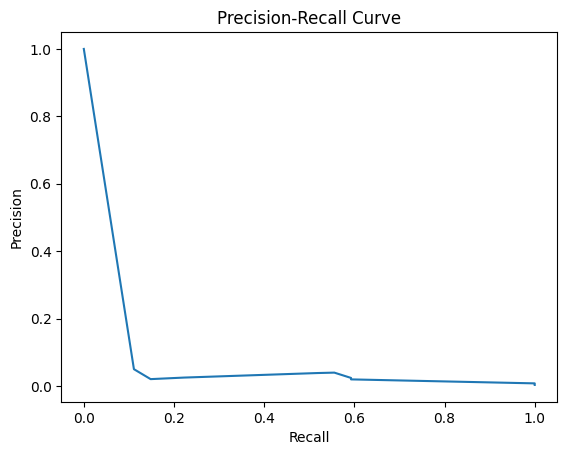

In [26]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [5]:
def calculate_metrics(y_true, y_pred, y_scores):
    metrics = {
        "Precision": precision_score(y_true, y_pred, average="binary"),
        "Recall": recall_score(y_true, y_pred, average="binary"),
        "F1-Score": f1_score(y_true, y_pred, average="binary"),
        "AUC": roc_auc_score(y_true, y_scores)
    }
    return metrics

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Submission Code 

## Extract and Format Variant Information

In [5]:
import pandas as pd
from cyvcf2 import VCF

In [6]:
vcf_file_path = "data/hd829/SNV.somatic.sweetelf.merged.clinical.ranked.vcf"

In [19]:
def parse_csq(fields, csq_str):
    csq = []
    annotation_list = csq_str.split(",")
    for annotation in annotation_list:   
        return csq.append(dict(zip(fields, annotation.split("|"))))

def parse_vcf(path_to_vcf):
    vcf = VCF(path_to_vcf)
    csq_fields = vcf.get_header_type("CSQ")["Description"][51:-1].split("|")
    data = []
    for variant in vcf:
        chrom = variant.CHROM
        pos = variant.POS
        ref = variant.REF
        alt = variant.ALT[0]
        info = variant.INFO
        aaf = variant.aaf 
        filter_value = variant.FILTER

        # extract INFO-keys
        csq_str = info.get("CSQ", "") 
        af, pp, con, vcqf, lin, clin = [float(x) for x in info.get("RankResult", "0|0|0|0|0|0").split("|")]   
        rank_score = float(info.get("RankScore")[2:])    
        clnsig = info.get("CLNSIG", "") 
        vaf = info.get("AF", "")
        coverage = info.get("DP", "")

        # Extract CSQ-keys 
        csq = parse_csq(csq_fields, csq_str)

        # Format strings for extracting controls
        chrom_pos = f"{chrom}_{pos}"
        ref_alt = f"{ref}_{alt}"
        
        data.append({
            "VARIANT": f"{chrom_pos}_{ref_alt}",
            "CHROM_POS": chrom_pos,
            "AF": af,
            "PP": pp,
            "CON": con,
            "VCQF": vcqf,
            "LIN": lin,
            "CLIN": clin,
            "CLNSIG": clnsig,
            "RANK_SCORE": rank_score,
            "PARSED_CSQ": csq,
            "AAF(aaf)": aaf,
            "FILTER": filter_value,
            "VAF(AF)": vaf,
            "COVERAGE(DP)": coverage
        })
    return pd.DataFrame(data)

In [20]:
# read VCF file into a pandas Dataframe 
df = parse_vcf(vcf_file_path)

In [33]:
df["CLNSIG"].unique()

array(['', 'Benign', 'Uncertain_significance', 'Likely_benign',
       'Benign/Likely_benign',
       'Conflicting_classifications_of_pathogenicity', 'Pathogenic',
       'drug_response', 'Pathogenic/Likely_pathogenic',
       'Conflicting_classifications_of_pathogenicity|drug_response|other',
       'Benign|drug_response', 'Pathogenic|other', 'Likely_pathogenic',
       'Likely_benign|other', 'Likely_pathogenic|association',
       'Pathogenic/Likely_pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|association',
       'not_provided', 'Likely_benign|drug_response|other'], dtype=object)

In [29]:
df[df["CLNSIG"] != ""].describe()

,AF,PP,CON,VCQF,LIN,CLIN,RANK_SCORE,AAF(aaf),VAF(AF),COVERAGE(DP)
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,-3.448232,0.093891,2.372990,2.068167,-0.165916,0.654662,1.575563,0.500322,0.286540,1677.110611
std,7.364502,0.399720,1.856441,1.726986,0.500446,2.096997,8.292973,0.012680,0.312296,1219.309526
min,-12.000000,0.000000,1.000000,-6.000000,-2.000000,-2.000000,-19.000000,0.500000,0.005039,50.000000
25%,-12.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-6.000000,0.500000,0.044605,769.000000
50%,0.000000,0.000000,1.000000,3.000000,0.000000,2.000000,3.000000,0.500000,0.120181,1421.000000
75%,4.000000,0.000000,3.000000,3.000000,0.000000,2.000000,10.000000,0.500000,0.451435,2415.000000
max,4.000000,2.000000,8.000000,3.000000,0.000000,6.000000,21.000000,1.000000,1.000000,10205.000000


# Process Data

## Classify Variants

In [40]:
groups = {
    "benign": ["Benign", "Likely_benign", "Benign/Likely_benign", "Benign|drug_response", "Likely_benign|other", "Likely_benign|drug_response|other"], 
    "pathogenic": ["Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic", "Pathogenic|other", "Likely_pathogenic|association", "Pathogenic/Likely_pathogenic|risk_factor"],
    "uncertain": ["Uncertain_significance", "Conflicting_classifications_of_pathogenicity", "Conflicting_classifications_of_pathogenicity|drug_response|other", "Conflicting_classifications_of_pathogenicity|association"],
    "other": ["not_provided", ""]
}
def class_group(clnsig):
    for k, v in groups.items():
        if clnsig in groups[k]:
            return k



In [45]:
for k in groups.keys():
    if "Benign/Likely_benign" in groups[k]:
        print(k)
    elif "Pathogenic" in groups[k]:
        print(f"pathogenic {k}")
    print(f"other")

benign
other
pathogenic pathogenic
other
other
other


In [34]:
test = df.copy()

In [37]:
test["GROUP"] = test["CLNSIG"].apply(class_group)

In [44]:
test[test["GROUP"] == "uncertain"]

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,PARSED_CSQ,AAF(aaf),FILTER,VAF(AF),COVERAGE(DP),GROUP
25,1_9776057_C_T,1_9776057,0.0,0.0,5.0,3.0,0.0,-2.0,Uncertain_significance,6.0,None,0.5,None,0.055518,2936,uncertain
49,1_27023007_AGGC_A,1_27023007,4.0,0.0,5.0,3.0,0.0,2.0,Uncertain_significance,14.0,None,0.5,None,0.014808,2161,uncertain
98,1_43817930_C_T,1_43817930,0.0,2.0,5.0,3.0,0.0,-2.0,Conflicting_classifications_of_pathogenicity,8.0,None,0.5,None,0.053633,3468,uncertain
200,1_92944314_C_CAGAG,1_92944314,4.0,0.0,5.0,0.0,0.0,2.0,Conflicting_classifications_of_pathogenicity,11.0,None,0.5,triallelic_site,0.079057,343,uncertain
201,1_92944314_C_CAGAGAGAG,1_92944314,4.0,0.0,5.0,0.0,0.0,2.0,Conflicting_classifications_of_pathogenicity,11.0,None,0.5,triallelic_site,0.038835,314,uncertain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8006,X_70360588_GAGC_G,X_70360588,0.0,0.0,5.0,3.0,0.0,2.0,Uncertain_significance,10.0,None,0.5,None,0.017164,1340,uncertain
8007,X_70360623_ACAG_A,X_70360623,0.0,0.0,5.0,3.0,0.0,2.0,Uncertain_significance,10.0,None,0.5,None,0.016541,1330,uncertain
8010,X_70360679_GGCA_G,X_70360679,0.0,0.0,5.0,0.0,0.0,2.0,Conflicting_classifications_of_pathogenicity,7.0,None,0.5,triallelic_site,0.049949,977,uncertain
8011,X_70361097_ACAG_A,X_70361097,0.0,0.0,5.0,0.0,0.0,2.0,Conflicting_classifications_of_pathogenicity,7.0,None,0.5,triallelic_site,0.107031,1273,uncertain


In [90]:
GROUPS_WITH_LABELS = {
    "benign": ["Benign", "Likely_benign", "Benign/Likely_benign", "Benign|drug_response", "Likely_benign|other", "Likely_benign|drug_response|other"], 
    "pathogenic": ["Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic", "Pathogenic|other", "Likely_pathogenic|association", "Pathogenic/Likely_pathogenic|risk_factor"],
    "uncertain": ["Uncertain_significance", "Conflicting_classifications_of_pathogenicity", "Conflicting_classifications_of_pathogenicity|drug_response|other", "Conflicting_classifications_of_pathogenicity|association"],
    "other": ["not_provided", ""]
}

        
def group_variants(df, from_col="CLNSIG", groups=GROUPS_WITH_LABELS, to_col="GROUP"):
    """ 
    Groups variants by 'groups' based on information in 'from_col'.
    Args:
    df (pd.DataFrame): data with variants to group
    from_col (str): the column in df to use for grouping (required in df)
    func (function): the function to apply on the 'from_col' values
    to_col (str): the name of the new column that will contain variant group labels
    Returns:
    df (pd.DataFrame): the df extended with 'to_column' values. 
    """
    
    def classify(clnsig):
        for group in groups.keys():
            if clnsig in groups[group]:
                return group
            return clnsig

    df[to_col] = df[from_col].apply(classify)
    return df

In [81]:
CLNSIG_VALUES = ["", "Benign", "Uncertain_significance", "Likely_benign",
       "Benign/Likely_benign",
       "Conflicting_classifications_of_pathogenicity", "Pathogenic",
       "drug_response', 'Pathogenic/Likely_pathogenic",
       "Conflicting_classifications_of_pathogenicity|drug_response|other",
       "Benign|drug_response", "Pathogenic|other", "Likely_pathogenic",
       "Likely_benign|other', 'Likely_pathogenic|association",
       "Pathogenic/Likely_pathogenic|risk_factor",
       "Conflicting_classifications_of_pathogenicity|association",
       "not_provided", "Likely_benign|drug_response|other"]


In [102]:
group_variants(test.copy()).groupby(["GROUP"]).mean()

TypeError: agg function failed [how->mean,dtype->object]

In [77]:
test_grouped["CLNSIG"].unique()

array(['', 'Benign', 'Uncertain_significance', 'Likely_benign',
       'Benign/Likely_benign',
       'Conflicting_classifications_of_pathogenicity', 'Pathogenic',
       'drug_response', 'Pathogenic/Likely_pathogenic',
       'Conflicting_classifications_of_pathogenicity|drug_response|other',
       'Benign|drug_response', 'Pathogenic|other', 'Likely_pathogenic',
       'Likely_benign|other', 'Likely_pathogenic|association',
       'Pathogenic/Likely_pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|association',
       'not_provided', 'Likely_benign|drug_response|other'], dtype=object)

In [78]:
test[test["GROUP"] == "benign"]

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,PARSED_CSQ,AAF(aaf),FILTER,VAF(AF),COVERAGE(DP),GROUP
16,1_9770690_C_CAG,1_9770690,-12.0,0.0,1.0,0.0,0.0,2.0,Benign,-9.0,None,0.5,triallelic_site,0.136209,493,benign
22,1_9770714_C_G,1_9770714,4.0,0.0,1.0,3.0,0.0,2.0,Benign,10.0,None,0.5,None,0.134345,923,benign
27,1_9777586_G_C,1_9777586,0.0,0.0,1.0,3.0,0.0,-2.0,Benign,2.0,None,0.5,None,0.332424,2933,benign
29,1_9780738_T_G,1_9780738,0.0,0.0,1.0,3.0,0.0,2.0,Likely_benign,6.0,None,0.5,None,0.045800,1680,benign
31,1_9780987_T_C,1_9780987,-12.0,0.0,1.0,3.0,0.0,-2.0,Benign,-10.0,None,0.5,None,0.344630,1741,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8100,X_129148407_T_C,X_129148407,0.0,0.0,2.0,3.0,0.0,-2.0,Benign,3.0,None,0.5,None,0.093306,1479,benign
8101,X_129150144_C_G,X_129150144,-12.0,0.0,2.0,3.0,0.0,2.0,Benign,-5.0,None,0.5,None,0.100226,1327,benign
8112,X_133511988_G_A,X_133511988,-12.0,0.0,1.0,3.0,-2.0,-2.0,Benign,-12.0,None,0.5,None,1.000000,311,benign
8116,X_133547693_T_TA,X_133547693,0.0,0.0,5.0,0.0,0.0,2.0,Benign,7.0,None,0.5,triallelic_site,0.099119,905,benign


In [ ]:
def analyze_scores(df):
    """
    The function expects a DataFrame with a CLNSIG column 
    containing values like "Benign", "Pathogenic", etc.
    Returns a new DataFrame with two additional columns: 
    GROUP: Classifies each variant as benign, pathogenic, or other.
    Args:
    df (pd.DataFrame): the variant data
    label (str): the column in df to use for grouping the variants, default="CLNSIG"
    
    """
    # Define group classification terms
    benign_terms = {"Benign", "Likely_benign"}
    pathogenic_terms = {"Pathogenic", "Likely_pathogenic"}
    
    # Function to classify groups
    def classify_group(clnsig):
        if clnsig in benign_terms:
            return "benign"
        elif clnsig in pathogenic_terms:
            return "pathogenic"
        return "other"

    # Function to assign colors
    #def assign_color(group):
        #return {"benign": "blue", "pathogenic": "red", "other": "gray"}

    # Apply classification and color assignment
    df["GROUP"] = df["CLNSIG"].apply(classify_group)
    #df["COLOR"] = df["GROUP"].apply(assign_color)
    
    return df

def mark_controls(df, controls):
    control_set = set(controls["chrom_pos"])
    df["IS_CONTROL"] = df["CHROM_POS"].isin(control_set)
    return df

def subtract_clin_score(df):
    df["NO_CLIN_RANK_SCORE"] = df["RANK_SCORE"] - df["CLIN"]
    return df

In [4]:
controls = pd.read_csv("controls_match.tsv", sep="\t")

NameError: name 'pd' is not defined

In [148]:
df.head(1)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,no_value,12.0


In [147]:
df_ = df[df["GROUP"] == "benign"]

KeyError: 'GROUP'

In [144]:
df_.describe()

,AF,PP,CON,VCQF,LIN,CLIN,RANK_SCORE,NO_CLIN_RANK_SCORE,y_true,y_pred,REWEIGHTED_RANK_SCORE,VariantIndex
count,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.0,1223.000000,1223.000000,1223.000000
mean,-4.189697,0.033524,1.943581,2.124285,-0.201145,0.639411,0.349959,-0.289452,0.0,0.032706,1.002044,4060.787408
std,7.596407,0.235245,1.479568,1.764607,0.546165,1.909572,7.934997,7.313952,0.0,0.177940,7.578922,2462.720371
min,-12.000000,0.000000,1.000000,-6.000000,-2.000000,-2.000000,-19.000000,-17.000000,0.0,0.000000,-17.500000,16.000000
25%,-12.000000,0.000000,1.000000,3.000000,0.000000,-2.000000,-6.000000,-8.000000,0.0,0.000000,-6.500000,1882.500000
50%,0.000000,0.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,0.0,0.000000,1.500000,4071.000000
75%,4.000000,0.000000,3.000000,3.000000,0.000000,2.000000,8.000000,8.000000,0.0,0.000000,8.500000,6303.000000
max,4.000000,2.000000,8.000000,3.000000,0.000000,6.000000,14.000000,13.000000,0.0,1.000000,15.500000,8130.000000


In [15]:
df = analyze_scores(df)

In [16]:
df.head(2)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,no_value,12.0,other
1,1_4849384_T_C,1_4849384,4.0,0.0,1.0,3.0,0.0,2.0,no_value,10.0,other


In [17]:
df = mark_controls(df, controls)

In [18]:
df.head(1)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,IS_CONTROL
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,no_value,12.0,other,False


In [19]:
df = subtract_clin_score(df)

In [20]:
df.head(1)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,IS_CONTROL,NO_CLIN_RANK_SCORE
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,no_value,12.0,other,False,10.0


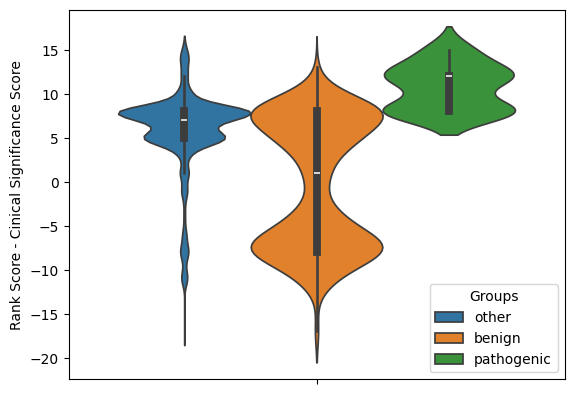

In [21]:
violin_plot_by_group(df, "NO_CLIN_RANK_SCORE")

In [22]:
# Prepare Data for Metrics Calculation

# extract the relevant columns (RANK_SCORE or NO_CLIN_RANK_SCORE, and the GROUP column for ground truth)

df["y_true"] = df["GROUP"].apply(lambda x: 1 if x == "pathogenic" else 0)  # Convert GROUP to binary labels
threshold = 10.0  # Example threshold for classification

# Predicted labels based on the threshold
df["y_pred"] = df["NO_CLIN_RANK_SCORE"].apply(lambda x: 1 if x >= threshold else 0)

# Scores to use for AUC calculation
y_true = df["y_true"].values  # Ground truth labels
y_pred = df["y_pred"].values  # Predicted binary labels
y_scores = df["NO_CLIN_RANK_SCORE"].values  # Continuous scores

In [23]:
# Call the calculate_metrics Function

metrics = calculate_metrics(y_true, y_pred, y_scores)
print("Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

Metrics:
Precision: 0.02
Recall: 0.59
F1-Score: 0.05
AUC: 0.88


## Separation Benign Pathogenic - CLNSIG-Annoted
Analyze variants that have annotations from ClinVar. 
1. Filter annotated variants
2. Compare group statistics
3. Identify overlaps
4. Evaluate thresholds
5. Scatterplot with controls highlighted

In [24]:
# Step 1: Filter annotated variants
filtered_df = filter_annotated_variants(df).copy()  # Ensure it's an independent DataFrame

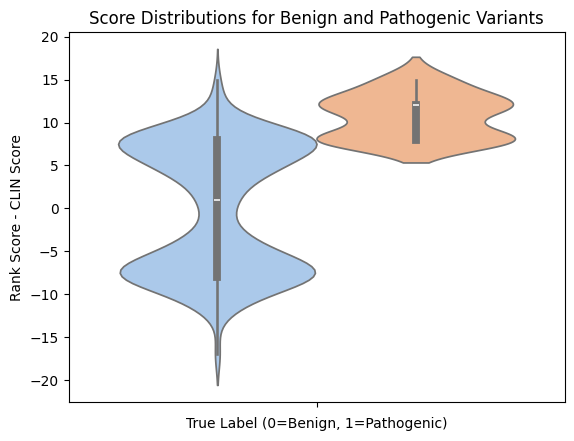

In [58]:
sns.violinplot(data=filtered_df, hue="y_true", y="NO_CLIN_RANK_SCORE", palette="pastel", legend=False)
plt.title("Score Distributions for Benign and Pathogenic Variants")
plt.xlabel("True Label (0=Benign, 1=Pathogenic)")
plt.ylabel("Rank Score - CLIN Score")
plt.savefig("score_dist_ben_path_violin.png")
plt.show()

In [97]:
filtered_df.groupby("GROUP")["NO_CLIN_RANK_SCORE"].median()
filtered_df.describe()

,AF,PP,CON,VCQF,LIN,CLIN,RANK_SCORE,NO_CLIN_RANK_SCORE,y_true,y_pred
count,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000
mean,-3.951143,0.055162,2.115839,2.108747,-0.193853,0.758077,0.892829,0.134752,0.021277,0.056738
std,7.567205,0.307809,1.726115,1.757138,0.537485,2.039579,8.305552,7.522519,0.144362,0.231432
min,-12.000000,0.000000,1.000000,-6.000000,-2.000000,-2.000000,-19.000000,-17.000000,0.000000,0.000000
25%,-12.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-6.000000,-7.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,3.000000,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,4.000000,0.000000,3.000000,3.000000,0.000000,2.000000,9.000000,8.000000,0.000000,0.000000
max,4.000000,2.000000,8.000000,3.000000,0.000000,6.000000,21.000000,15.000000,1.000000,1.000000


Statistics for (Rank Score - CLIN Score) by GROUP:

             count       mean       std   min   25%   50%   75%   max
GROUP                                                                
benign      1223.0  -0.289452  7.313952 -17.0  -8.0   1.0   8.0  13.0
other         19.0  12.368421  2.499123   8.0  10.0  14.0  14.0  15.0
pathogenic    27.0  10.740741  2.565940   8.0   8.0  12.0  12.0  15.0



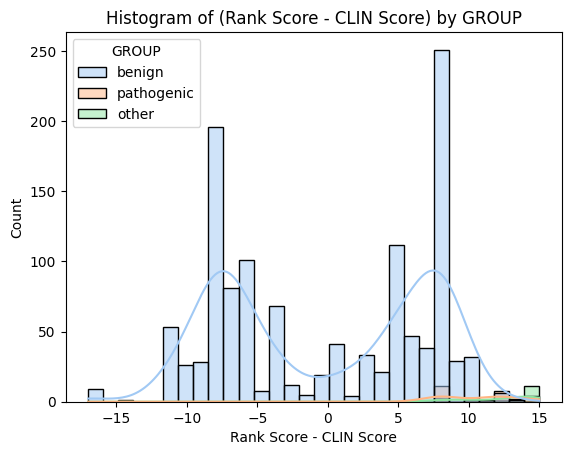

In [59]:
# Step 2: Compare group statistics
compare_group_statistics(filtered_df)

In [45]:
# Step 3: Identify overlaps
threshold_low, threshold_high = 4, 8  # Example thresholds
overlap_df = identify_overlaps(filtered_df, threshold_low, threshold_high)

Number of overlapping variants between 4 and 8: 197


In [47]:
pd.DataFrame(overlap_df).describe()
#overlaps_describe = overlaps_describe.reset_index()

,AF,PP,CON,VCQF,LIN,CLIN,RANK_SCORE,NO_CLIN_RANK_SCORE,y_true,y_pred
count,197.000000,197.0,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.0,197.0
mean,3.086294,0.0,1.649746,1.385787,-0.497462,1.106599,6.730964,5.624365,0.0,0.0
std,1.609178,0.0,1.299200,1.499456,0.780008,1.670209,1.727244,0.789611,0.0,0.0
min,0.000000,0.0,1.000000,0.000000,-2.000000,-2.000000,3.000000,5.000000,0.0,0.0
25%,2.000000,0.0,1.000000,0.000000,-1.000000,2.000000,7.000000,5.000000,0.0,0.0
50%,4.000000,0.0,1.000000,0.000000,0.000000,2.000000,7.000000,5.000000,0.0,0.0
75%,4.000000,0.0,2.000000,3.000000,0.000000,2.000000,8.000000,6.000000,0.0,0.0
max,4.000000,0.0,5.000000,3.000000,0.000000,2.000000,9.000000,7.000000,0.0,0.0


In [49]:
# Step 4: Evaluate thresholds
thresholds = [2, 4, 6, 8, 10]
evaluate_thresholds(filtered_df, thresholds)

Threshold: 2, Precision: 0.04, Recall: 1.00
Threshold: 4, Precision: 0.05, Recall: 1.00
Threshold: 6, Precision: 0.06, Recall: 1.00
Threshold: 8, Precision: 0.07, Recall: 1.00
Threshold: 10, Precision: 0.22, Recall: 0.59


In [108]:
def scatter_plot_with_controls(df):
    plt.figure(figsize=(10, 6))

    sns.scatterplot(data=filtered_df, x=filtered_df.index, y="NO_CLIN_RANK_SCORE", hue="GROUP")
    # Scatter controls
    controls = df[df["IS_CONTROL"]]
    plt.scatter(
        controls.index, controls["RANK_SCORE"],
        c="gold", edgecolor="black", s=50, label="Positive Controls"
    )
    plt.xlabel("Variant Index", fontsize=12)
    plt.ylabel("(Rank Score - CLIN Score)", fontsize=12)
    #plt.xticks([])
    plt.title("Scatterplot with Pathogenic Controls Highlighted")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("scatter_controls.png")
    plt.show()

    # Add threshold line (optional)
    #threshold = 10
    #plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    # Titles and labels
   # plt.title("Controls Relative All Variants", fontsize=14)
    #plt.xlabel("Variant Index", fontsize=12)
   # plt.ylabel("Rank Score", fontsize=12)

    #plt.savefig("scatter_plot_highlighted_controls.png")
    
    #plt.show()

In [35]:
filtered_df.head(1)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,IS_CONTROL,NO_CLIN_RANK_SCORE,y_true,y_pred
16,1_9770690_C_CAG,1_9770690,-12.0,0.0,1.0,0.0,0.0,2.0,Benign,-9.0,benign,False,-11.0,0,0


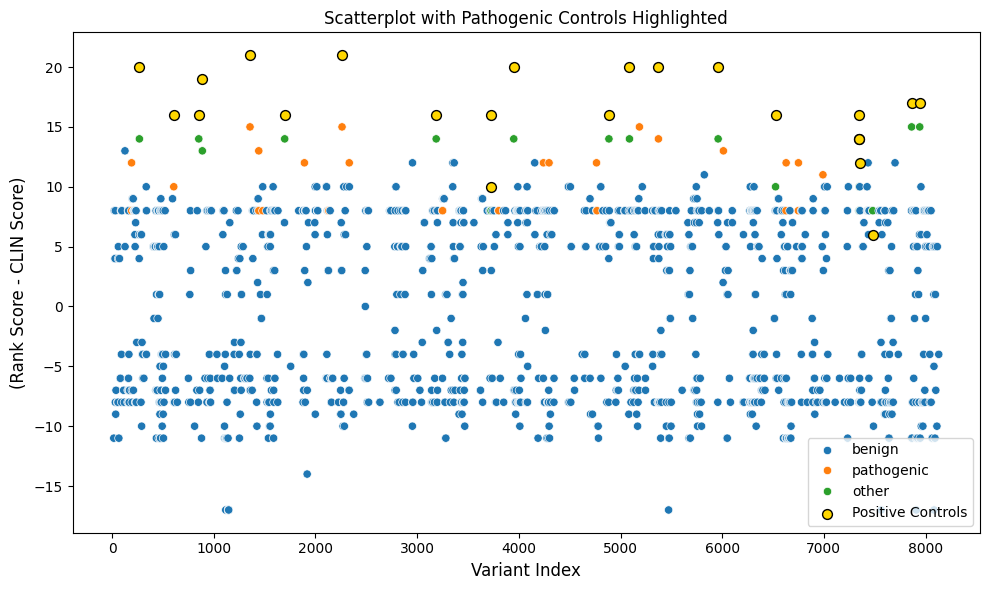

In [109]:
scatter_plot_with_controls(filtered_df)

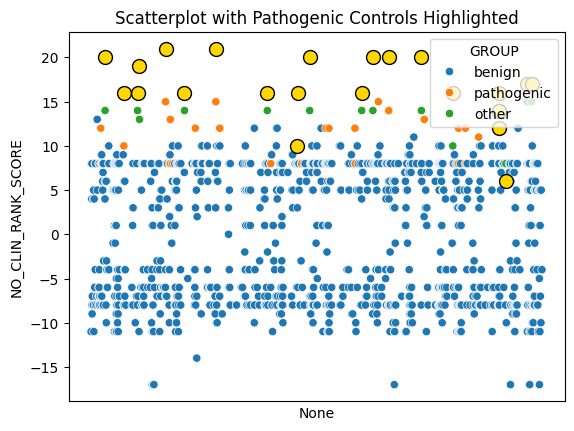

In [45]:
sns.scatterplot(data=filtered_df, x=filtered_df.index, y="NO_CLIN_RANK_SCORE", hue="GROUP")
# Scatter controls
controls = df[df["IS_CONTROL"]]
plt.scatter(
    controls.index, controls["RANK_SCORE"],
    c="gold", edgecolor="black", s=100, label="Positive Controls"
)
plt.xticks([])
plt.title("Scatterplot with Pathogenic Controls Highlighted")
plt.savefig("scatter_controls.png")
plt.show()

In [55]:
# Step 5: Scatterplot with controls highlighted
scatterplot_with_controls_clnsig(filtered_df)

ValueError: Could not interpret value `is_control` for `style`. An entry with this name does not appear in `data`.

## Investigate Low-Scoring Controls
This function identifies controls (is_control=True) that have a RANK_SCORE below a given threshold (e.g., 10).
	•	Output:
	•	Number of low-scoring controls.
	•	Descriptive statistics for the feature components (AF, PP, etc.).
	•	Boxplot for the distributions of these feature components.

In [127]:
df.head().sort_values(by="CLIN", ascending=True)


,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,IS_CONTROL,NO_CLIN_RANK_SCORE,y_true,y_pred,REWEIGHTED_RANK_SCORE,VariantIndex
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,no_value,12.0,other,False,10.0,0,1,12.5,0
1,1_4849384_T_C,1_4849384,4.0,0.0,1.0,3.0,0.0,2.0,no_value,10.0,other,False,8.0,0,0,9.5,1
2,1_4955824_T_TA,1_4955824,4.0,0.0,0.0,0.0,0.0,2.0,no_value,6.0,other,False,4.0,0,0,5.0,2
3,1_4955862_C_T,1_4955862,4.0,0.0,0.0,3.0,-1.0,2.0,no_value,8.0,other,False,6.0,0,0,7.0,3
4,1_6246921_G_T,1_6246921,4.0,0.0,1.0,3.0,0.0,2.0,no_value,10.0,other,False,8.0,0,0,9.5,4


In [128]:
# 1. Investigate low-scoring controls
def investigate_low_scoring_controls(df, score_threshold=10):
    """
    Investigate controls with low RANK_SCORE.
    """
    low_scoring_controls = df[(df["IS_CONTROL"]) & (df["RANK_SCORE"] < score_threshold)]
    print(f"Number of low-scoring controls (RANK_SCORE < {score_threshold}): {len(low_scoring_controls)}")
    print("\nDescriptive statistics for low-scoring controls:")
    print(low_scoring_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())
    
    # Boxplot for feature components
    low_scoring_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
    plt.title(f"Feature Components for Low-Scoring Controls (adjusted rank score < {score_threshold})")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.savefig("low_scoring_controls.png")
    plt.show()

    return low_scoring_controls

# 2. Decompose scoring system for overlap analysis
def analyze_overlap_features(df, lower_threshold=5, upper_threshold=15):
    """
    Analyze feature components for variants in the overlap region of RANK_SCORE.
    """
    overlap_df = df[(df["RANK_SCORE"] > lower_threshold) & (df["RANK_SCORE"] < upper_threshold)]
    print(f"Number of variants in the overlap region ({lower_threshold} < RANK_SCORE < {upper_threshold}): {len(overlap_df)}")
    print("\nDescriptive statistics for feature components in the overlap region:")
    print(overlap_df[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())
    
    # Boxplot for feature components in overlap
    overlap_df[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
    plt.title(f"Feature Components in Overlap Region ({lower_threshold} < adjusted rank score < {upper_threshold})")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.savefig("overlap_features.png")
    plt.show()

    return overlap_df

# 3. Visualize individual feature distributions for controls vs non-controls
def visualize_feature_distributions(df, feature):
    """
    Visualize distributions of a specific feature for controls and non-controls.
    """
    sns.boxplot(data=df, hue="IS_CONTROL", y=feature, palette="pastel")
    plt.title(f"{feature} Distribution for Controls and Non-Controls")
    plt.xlabel("Control Status")
    plt.ylabel(feature)
    plt.savefig(f"feature_distribution_{feature}.png")
    plt.show()

# Example Usage
def main_investigate_controls(df):
    # Step 1: Investigate low-scoring controls
    low_scoring_controls = investigate_low_scoring_controls(df, score_threshold=10)

    # Step 2: Analyze overlap features
    overlap_df = analyze_overlap_features(df, lower_threshold=5, upper_threshold=15)

    # Step 3: Visualize individual feature distributions
    for feature in ["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]:
        visualize_feature_distributions(df, feature)

    return low_scoring_controls, overlap_df

# Uncomment and run when the dataset `df` is defined
# low_scoring_controls, overlap_df = main_investigate_controls(df)

Number of variants in the overlap region (5 < RANK_SCORE < 15): 6258

Descriptive statistics for feature components in the overlap region:
                AF           PP          CON         VCQF          LIN  \
count  6258.000000  6258.000000  6258.000000  6258.000000  6258.000000   
mean      3.719080     0.029083     1.350112     2.104506    -0.129275   
std       0.991424     0.223556     1.362874     1.372907     0.422028   
min       0.000000     0.000000     0.000000     0.000000    -2.000000   
25%       4.000000     0.000000     1.000000     0.000000     0.000000   
50%       4.000000     0.000000     1.000000     3.000000     0.000000   
75%       4.000000     0.000000     1.000000     3.000000     0.000000   
max       4.000000     2.000000     8.000000     3.000000     0.000000   

              CLIN  
count  6258.000000  
mean      1.866731  
std       0.772391  
min      -2.000000  
25%       2.000000  
50%       2.000000  
75%       2.000000  
max       6.000000  


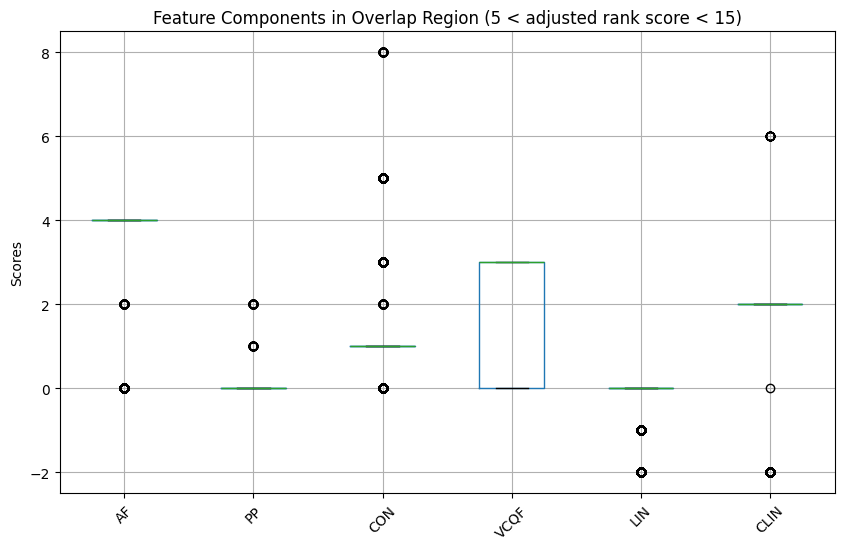

In [130]:
overlap_df = analyze_overlap_features(df, lower_threshold=5, upper_threshold=15)

Number of low-scoring controls (RANK_SCORE < 10): 1

Descriptive statistics for low-scoring controls:
        AF   PP  CON  VCQF  LIN  CLIN
count  1.0  1.0  1.0   1.0  1.0   1.0
mean   0.0  0.0  5.0   3.0  0.0   0.0
std    NaN  NaN  NaN   NaN  NaN   NaN
min    0.0  0.0  5.0   3.0  0.0   0.0
25%    0.0  0.0  5.0   3.0  0.0   0.0
50%    0.0  0.0  5.0   3.0  0.0   0.0
75%    0.0  0.0  5.0   3.0  0.0   0.0
max    0.0  0.0  5.0   3.0  0.0   0.0


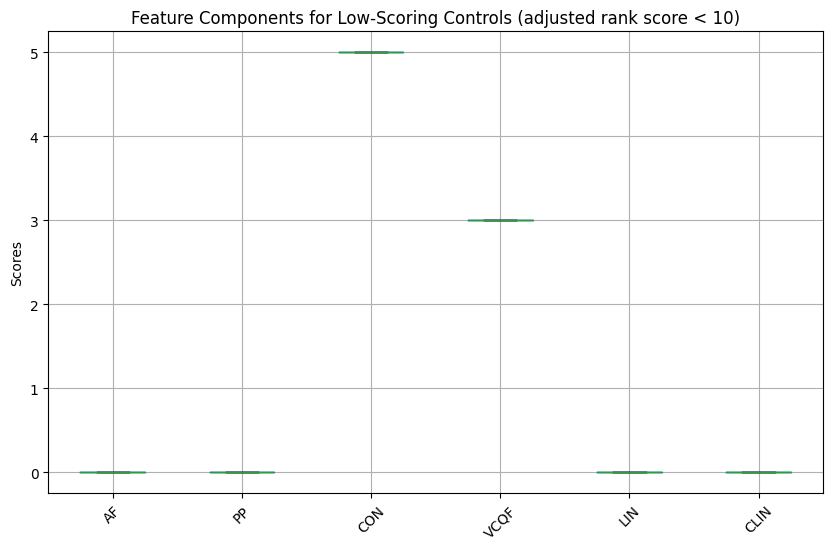

Number of variants in the overlap region (5 < RANK_SCORE < 15): 6258

Descriptive statistics for feature components in the overlap region:
                AF           PP          CON         VCQF          LIN  \
count  6258.000000  6258.000000  6258.000000  6258.000000  6258.000000   
mean      3.719080     0.029083     1.350112     2.104506    -0.129275   
std       0.991424     0.223556     1.362874     1.372907     0.422028   
min       0.000000     0.000000     0.000000     0.000000    -2.000000   
25%       4.000000     0.000000     1.000000     0.000000     0.000000   
50%       4.000000     0.000000     1.000000     3.000000     0.000000   
75%       4.000000     0.000000     1.000000     3.000000     0.000000   
max       4.000000     2.000000     8.000000     3.000000     0.000000   

              CLIN  
count  6258.000000  
mean      1.866731  
std       0.772391  
min      -2.000000  
25%       2.000000  
50%       2.000000  
75%       2.000000  
max       6.000000  


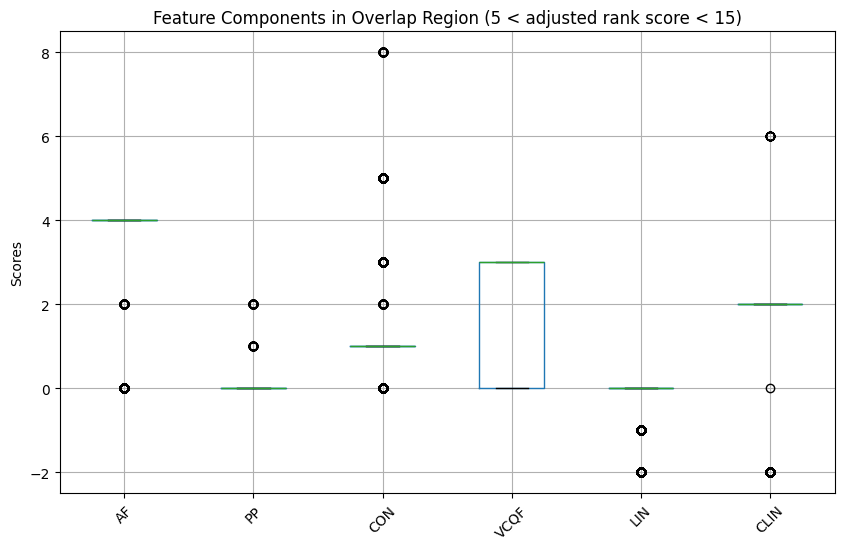

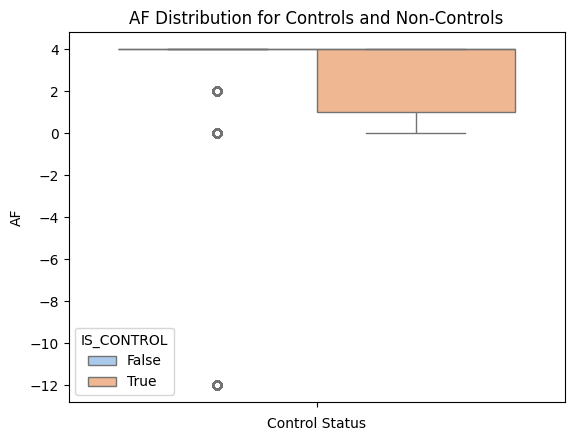

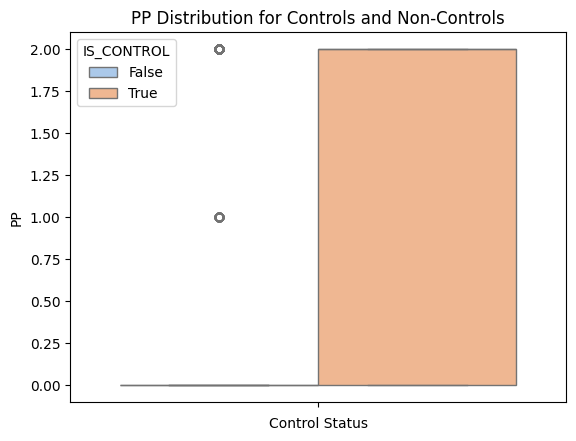

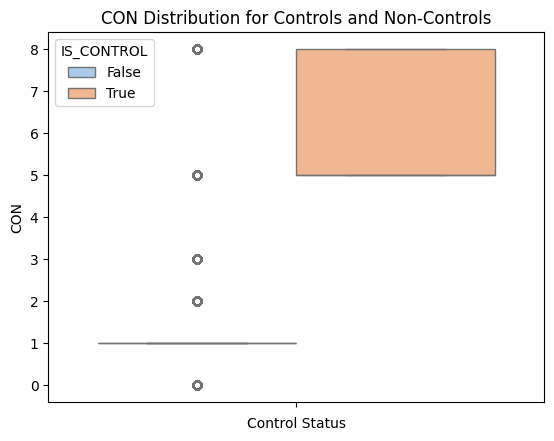

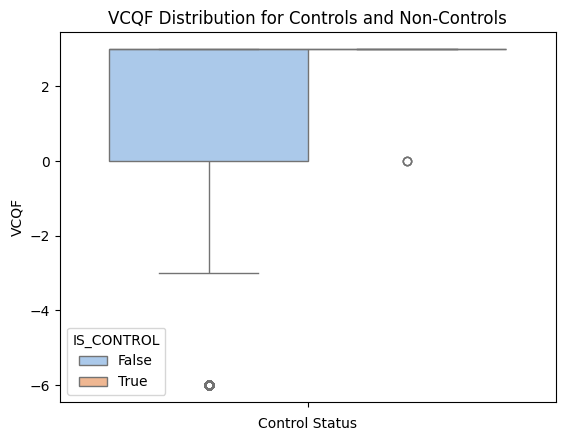

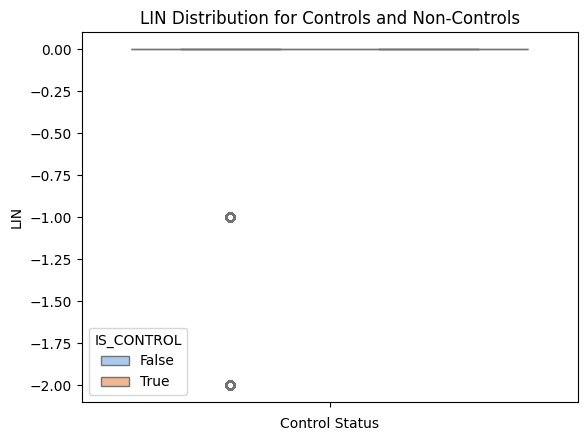

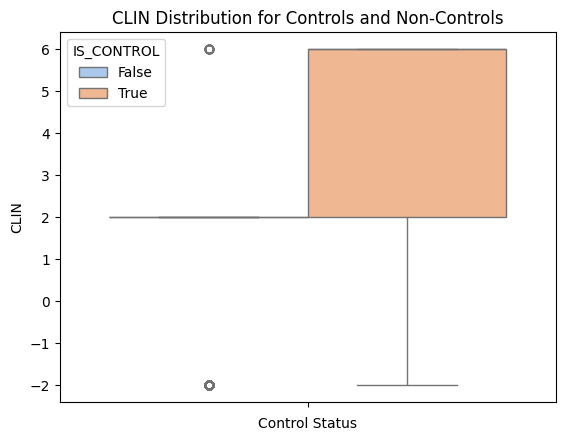

In [122]:
low_scoring_controls, overlap_df = main_investigate_controls(df)

In [98]:
low_scoring_controls = df[(df["IS_CONTROL"]) & (df["RANK_SCORE"] < 10)]
print(low_scoring_controls)

              VARIANT    CHROM_POS   AF   PP  CON  VCQF  LIN  CLIN  \
7481  21_36206711_C_T  21_36206711  0.0  0.0  5.0   3.0  0.0  -2.0   

                      CLNSIG  RANK_SCORE  IS_CONTROL  NO_CLIN_RANK_SCORE  \
7481  Uncertain_significance         6.0        True                 8.0   

      GROUP  y_true  y_pred  
7481  other       0       0  


In [113]:
weights = {"AF": 1.0, "PP": 1.0, "CON": 1.5, "VCQF": 1.0, "LIN": 1.0, "CLIN": 0.5}
df["REWEIGHTED_RANK_SCORE"] = (
    df["AF"] * weights["AF"] +
    df["PP"] * weights["PP"] +
    df["CON"] * weights["CON"] +
    df["VCQF"] * weights["VCQF"] +
    df["LIN"] * weights["LIN"] +
    df["CLIN"] * weights["CLIN"]
)

In [114]:
low_scoring_controls = df[(df["IS_CONTROL"]) & (df["REWEIGHTED_RANK_SCORE"] < 10)]

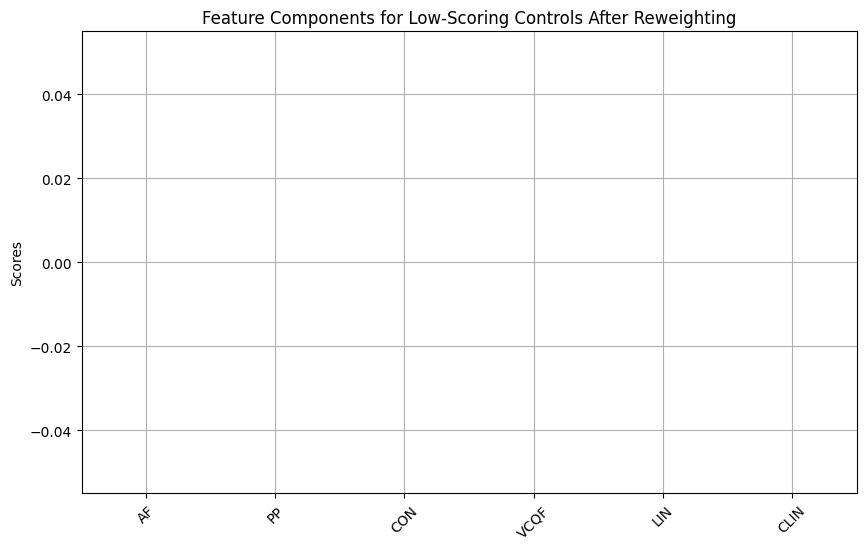

In [115]:
low_scoring_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
plt.title("Feature Components for Low-Scoring Controls After Reweighting")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.show()

In [102]:
low_scoring_controls.describe()

,AF,PP,CON,VCQF,LIN,CLIN,RANK_SCORE,NO_CLIN_RANK_SCORE,y_true,y_pred,REWEIGHTED_RANK_SCORE
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,0.0,5.0,3.0,0.0,-2.0,6.0,8.0,0.0,0.0,9.5
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,5.0,3.0,0.0,-2.0,6.0,8.0,0.0,0.0,9.5
25%,0.0,0.0,5.0,3.0,0.0,-2.0,6.0,8.0,0.0,0.0,9.5
50%,0.0,0.0,5.0,3.0,0.0,-2.0,6.0,8.0,0.0,0.0,9.5
75%,0.0,0.0,5.0,3.0,0.0,-2.0,6.0,8.0,0.0,0.0,9.5
max,0.0,0.0,5.0,3.0,0.0,-2.0,6.0,8.0,0.0,0.0,9.5


Number of low-scoring controls (RANK_SCORE < 10): 1

Descriptive statistics for low-scoring controls:
        AF   PP  CON  VCQF  LIN  CLIN
count  1.0  1.0  1.0   1.0  1.0   1.0
mean   0.0  0.0  5.0   3.0  0.0   0.0
std    NaN  NaN  NaN   NaN  NaN   NaN
min    0.0  0.0  5.0   3.0  0.0   0.0
25%    0.0  0.0  5.0   3.0  0.0   0.0
50%    0.0  0.0  5.0   3.0  0.0   0.0
75%    0.0  0.0  5.0   3.0  0.0   0.0
max    0.0  0.0  5.0   3.0  0.0   0.0


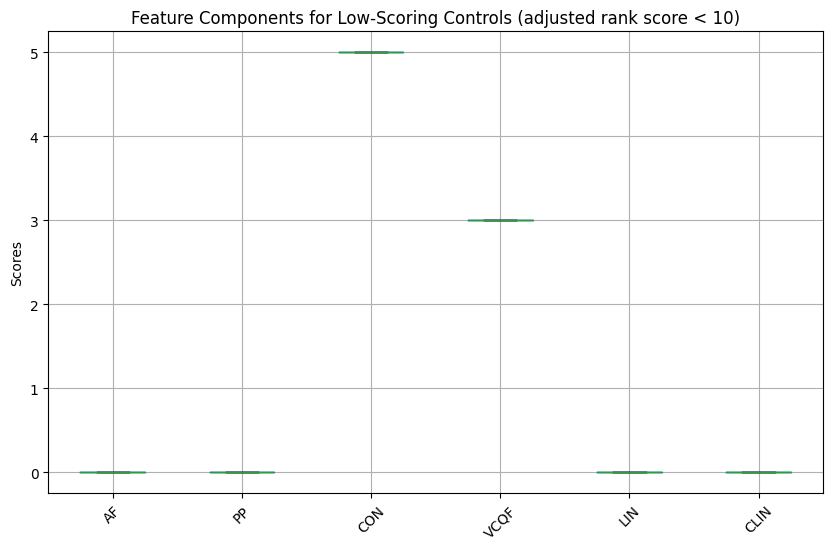

In [116]:
# 1. Investigate low-scoring controls
df_low_controls = investigate_low_scoring_controls(df)

In [108]:
df.loc[(df["IS_CONTROL"]) & (df["CLNSIG"] == "Uncertain_significance"), "CLIN"] = 0

In [117]:
df.loc[(df["IS_CONTROL"]) & (df["GROUP"] == "other"), "GROUP"] = "control_uncertain"

In [118]:
print(df.loc[df["VARIANT"] == "21_36206711_C_T", ["RANK_SCORE", "NO_CLIN_RANK_SCORE", "CLIN"]])

      RANK_SCORE  NO_CLIN_RANK_SCORE  CLIN
7481         6.0                 8.0   0.0


In [131]:
# Implementation to handle the low-scoring controls

# 1. Adjust Handling of `CLIN` for Controls
def adjust_clin_for_controls(df):
    """
    Neutralize negative `CLIN` contributions for controls with `Uncertain_significance`.
    """
    df.loc[(df["IS_CONTROL"]) & (df["CLNSIG"] == "Uncertain_significance"), "CLIN"] = 0
    print("Adjusted CLIN values for controls with Uncertain_significance.")
    return df

# 2. Reweight Scoring Formula
def reweight_scoring_formula(df, weights):
    """
    Reweight the scoring formula and recalculate the RANK_SCORE.
    """
    df["REWEIGHTED_RANK_SCORE"] = (
        df["AF"] * weights["AF"] +
        df["PP"] * weights["PP"] +
        df["CON"] * weights["CON"] +
        df["VCQF"] * weights["VCQF"] +
        df["LIN"] * weights["LIN"] +
        df["CLIN"] * weights["CLIN"]
    )
    print("Recalculated RANK_SCORE using new weights.")
    return df

# 3. Update Grouping for Controls
def update_control_grouping(df):
    """
    Reassign the group for controls with `Uncertain_significance` to `control_uncertain`.
    """
    df.loc[(df["IS_CONTROL"]) & (df["GROUP"] == "other"), "GROUP"] = "control_uncertain"
    print("Updated GROUP for controls with Uncertain_significance.")
    return df

# 4. Verify Changes for Specific Controls
def verify_control_updates(df, variant_id):
    """
    Print updated details for a specific control variant.
    """
    control_data = df.loc[df["VARIANT"] == variant_id, ["RANK_SCORE", "NO_CLIN_RANK_SCORE", "CLIN", "GROUP"]]
    print(f"Updated details for variant {variant_id}:")
    print(control_data)

# Example Usage
def main_handle_low_scoring_controls(df):
    # Step 1: Adjust CLIN values for controls
    df = adjust_clin_for_controls(df)

    # Step 2: Reweight scoring formula
    weights = {"AF": 1.0, "PP": 1.0, "CON": 1.5, "VCQF": 1.0, "LIN": 1.0, "CLIN": 0.5}
    df = reweight_scoring_formula(df, weights)

    # Step 3: Update control grouping
    df = update_control_grouping(df)

    # Step 4: Verify changes for the low-scoring control
    verify_control_updates(df, variant_id="21_36206711_C_T")

    return df

# Uncomment and run when `df` is defined
# df = main_handle_low_scoring_controls(df)

In [132]:
df = main_handle_low_scoring_controls(df)

Adjusted CLIN values for controls with Uncertain_significance.
Recalculated RANK_SCORE using new weights.
Updated GROUP for controls with Uncertain_significance.
Updated details for variant 21_36206711_C_T:
      RANK_SCORE  NO_CLIN_RANK_SCORE  CLIN              GROUP
7481         6.0                 8.0   0.0  control_uncertain


In [133]:
overlap_controls = df[(df["IS_CONTROL"]) & (df["RANK_SCORE"] > 5) & (df["RANK_SCORE"] < 15)]
print(overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())

            AF        PP       CON      VCQF  LIN      CLIN
count  5.00000  5.000000  5.000000  5.000000  5.0  5.000000
mean   1.60000  0.400000  6.200000  1.800000  0.0  1.600000
std    2.19089  0.894427  1.643168  1.643168  0.0  2.966479
min    0.00000  0.000000  5.000000  0.000000  0.0 -2.000000
25%    0.00000  0.000000  5.000000  0.000000  0.0  0.000000
50%    0.00000  0.000000  5.000000  3.000000  0.0  2.000000
75%    4.00000  0.000000  8.000000  3.000000  0.0  2.000000
max    4.00000  2.000000  8.000000  3.000000  0.0  6.000000


In [134]:
updated_overlap_controls = df[(df["IS_CONTROL"]) & (df["REWEIGHTED_RANK_SCORE"] > 5) & (df["REWEIGHTED_RANK_SCORE"] < 15)]
print(updated_overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN", "REWEIGHTED_RANK_SCORE"]].describe())

        AF   PP  CON  VCQF  LIN      CLIN  REWEIGHTED_RANK_SCORE
count  2.0  2.0  2.0   2.0  2.0  2.000000               2.000000
mean   0.0  0.0  5.0   3.0  0.0  1.000000              11.000000
std    0.0  0.0  0.0   0.0  0.0  1.414214               0.707107
min    0.0  0.0  5.0   3.0  0.0  0.000000              10.500000
25%    0.0  0.0  5.0   3.0  0.0  0.500000              10.750000
50%    0.0  0.0  5.0   3.0  0.0  1.000000              11.000000
75%    0.0  0.0  5.0   3.0  0.0  1.500000              11.250000
max    0.0  0.0  5.0   3.0  0.0  2.000000              11.500000


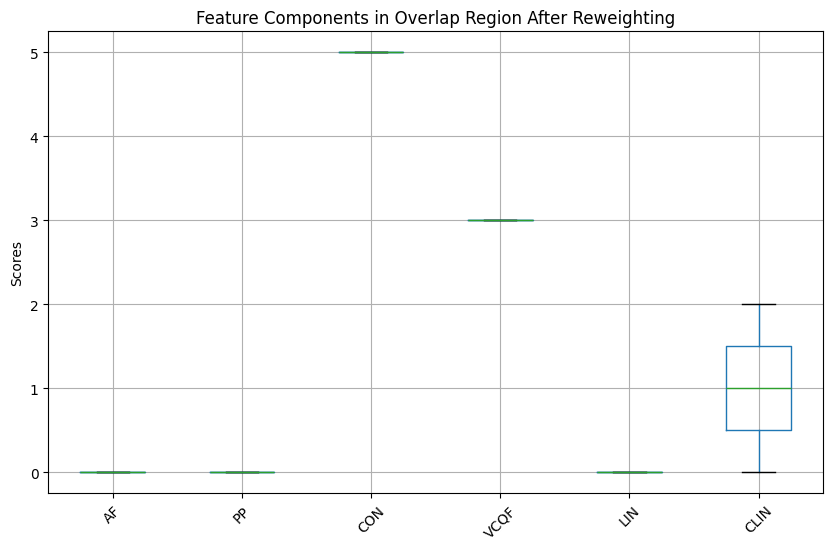

In [138]:
updated_overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
plt.title("Feature Components in Overlap Region After Reweighting")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.show()

In [139]:
weights = {"AF": 1.0, "PP": 1.0, "CON": 1.2, "VCQF": 1.2, "LIN": 1.0, "CLIN": 0.5}
df["REWEIGHTED_RANK_SCORE"] = (
    df["AF"] * weights["AF"] +
    df["PP"] * weights["PP"] +
    df["CON"] * weights["CON"] +
    df["VCQF"] * weights["VCQF"] +
    df["LIN"] * weights["LIN"] +
    df["CLIN"] * weights["CLIN"]
)

In [140]:
df[(df["IS_CONTROL"]) & (df["RANK_SCORE"] > 5) & (df["RANK_SCORE"] < 15)]

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,IS_CONTROL,NO_CLIN_RANK_SCORE,y_true,y_pred,REWEIGHTED_RANK_SCORE,VariantIndex
3727,9_5070021_TTCACAA_T,9_5070021,0.0,0.0,5.0,3.0,0.0,2.0,no_value,10.0,control_uncertain,True,8.0,0,0,10.6,3727
7349,20_31022441_A_AGG,20_31022441,4.0,0.0,8.0,0.0,0.0,2.0,no_value,14.0,control_uncertain,True,12.0,0,1,14.6,7349
7350,20_31022441_AG_A,20_31022441,0.0,0.0,8.0,0.0,0.0,6.0,no_value,14.0,control_uncertain,True,8.0,0,0,12.6,7350
7351,20_31022903_G_T,20_31022903,4.0,2.0,5.0,3.0,0.0,-2.0,no_value,12.0,control_uncertain,True,14.0,0,1,14.6,7351
7481,21_36206711_C_T,21_36206711,0.0,0.0,5.0,3.0,0.0,0.0,Uncertain_significance,6.0,control_uncertain,True,8.0,0,0,9.6,7481


In [126]:
df["CLIN"] = df["CLIN"].apply(lambda x: 0 if x < 0 else x)

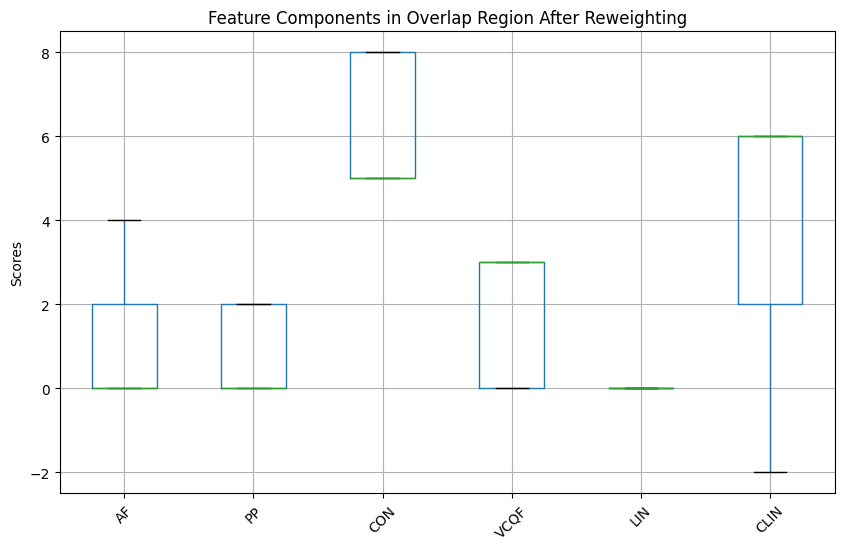

In [141]:
updated_overlap_controls = df[(df["IS_CONTROL"]) & (df["REWEIGHTED_RANK_SCORE"] > 5) & (df["REWEIGHTED_RANK_SCORE"] < 15)]
updated_overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
plt.title("Feature Components in Overlap Region After Reweighting")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.savefig("reweighted.png")
plt.show()

In [113]:
uncertain_variants = df[df["CLNSIG"] == "Uncertain_significance"]
uncertain_variants.head()
#print(uncertain_variants[["VARIANT", "RANK_SCORE", "NO_CLIN_RANK_SCORE", "GROUP"]].head())

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,IS_CONTROL,NO_CLIN_RANK_SCORE,GROUP,y_true,y_pred,REWEIGHTED_RANK_SCORE
25,1_9776057_C_T,1_9776057,0.0,0.0,5.0,3.0,0.0,-2.0,Uncertain_significance,6.0,False,8.0,other,0,0,9.5
49,1_27023007_AGGC_A,1_27023007,4.0,0.0,5.0,3.0,0.0,2.0,Uncertain_significance,14.0,False,12.0,other,0,1,15.5
267,1_115252204_C_T,1_115252204,4.0,2.0,5.0,3.0,0.0,2.0,Uncertain_significance,16.0,False,14.0,other,0,1,17.5
268,1_115256529_T_A,1_115256529,4.0,2.0,5.0,3.0,0.0,0.0,Uncertain_significance,20.0,True,14.0,control_uncertain,0,1,19.5
283,1_120459014_T_C,1_120459014,0.0,0.0,5.0,3.0,0.0,-2.0,Uncertain_significance,6.0,False,8.0,other,0,0,9.5


In [314]:
low_scoring_controls[["CLIN", "RANK_SCORE"]].describe()

,CLIN,RANK_SCORE
count,1.0,1.0
mean,-2.0,6.0
std,NaN,NaN
min,-2.0,6.0
25%,-2.0,6.0
50%,-2.0,6.0
75%,-2.0,6.0
max,-2.0,6.0


In [64]:
metrics = calculate_metrics(y_true, y_pred, y_scores)
print("Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

Metrics:
Precision: 0.02
Recall: 0.59
F1-Score: 0.05
AUC: 0.88


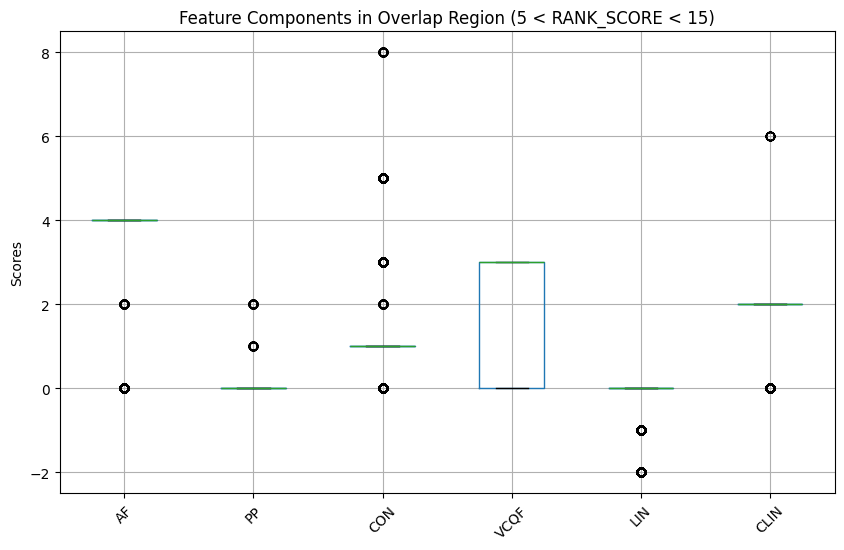

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,IS_CONTROL,NO_CLIN_RANK_SCORE,REWEIGHTED_RANK_SCORE,FINE_TUNED_RANK_SCORE,y_pred,y_true,REFINED_RANK_SCORE
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,no_value,12.0,other,False,10.0,13.0,15.2,0,0,14.0
1,1_4849384_T_C,1_4849384,4.0,0.0,1.0,3.0,0.0,2.0,no_value,10.0,other,False,8.0,11.0,13.6,0,0,12.0
2,1_4955824_T_TA,1_4955824,4.0,0.0,0.0,0.0,0.0,2.0,no_value,6.0,other,False,4.0,7.0,9.2,0,0,8.0
3,1_4955862_C_T,1_4955862,4.0,0.0,0.0,3.0,-1.0,2.0,no_value,8.0,other,False,6.0,9.0,11.8,0,0,10.5
4,1_6246921_G_T,1_6246921,4.0,0.0,1.0,3.0,0.0,2.0,no_value,10.0,other,False,8.0,11.0,13.6,0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8138,X_154317640_ATG_A,X_154317640,4.0,0.0,1.0,0.0,0.0,2.0,no_value,7.0,other,False,5.0,8.0,10.0,0,0,9.0
8139,X_154317640_ATGTG_A,X_154317640,4.0,0.0,1.0,0.0,0.0,2.0,no_value,7.0,other,False,5.0,8.0,10.0,0,0,9.0
8140,X_154317640_ATGTGTG_A,X_154317640,4.0,0.0,1.0,0.0,0.0,2.0,no_value,7.0,other,False,5.0,8.0,10.0,0,0,9.0
8141,X_154317640_ATGTGTGTG_A,X_154317640,4.0,0.0,1.0,0.0,0.0,2.0,no_value,7.0,other,False,5.0,8.0,10.0,0,0,9.0


In [341]:
analyze_overlap_features(df)

In [65]:
## Investigate Feature Components for Overlapping Variants
overlap_controls = df[(df["IS_CONTROL"]) & (df["RANK_SCORE"] > 5) & (df["RANK_SCORE"] < 15)]
print(overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())

            AF        PP       CON      VCQF  LIN      CLIN
count  5.00000  5.000000  5.000000  5.000000  5.0  5.000000
mean   1.60000  0.400000  6.200000  1.800000  0.0  1.600000
std    2.19089  0.894427  1.643168  1.643168  0.0  2.966479
min    0.00000  0.000000  5.000000  0.000000  0.0 -2.000000
25%    0.00000  0.000000  5.000000  0.000000  0.0  0.000000
50%    0.00000  0.000000  5.000000  3.000000  0.0  2.000000
75%    4.00000  0.000000  8.000000  3.000000  0.0  2.000000
max    4.00000  2.000000  8.000000  3.000000  0.0  6.000000


In [326]:
# Recommended adjustments based on feature overlaps 
# 1. Adjust CLIN to Avoid Negative Penalties
def neutralize_negative_clin(df):
    """
    Set negative CLIN values to 0 to avoid penalizing controls.
    """
    df["CLIN"] = df["CLIN"].apply(lambda x: 0 if x < 0 else x)
    print("Negative CLIN values have been neutralized.")
    return df

# 2. Reweight Features in the Scoring Formula
def reweight_features(df, weights):
    """
    Apply new weights to feature components and recalculate RANK_SCORE.
    """
    df["REWEIGHTED_RANK_SCORE"] = (
        df["AF"] * weights["AF"] +
        df["PP"] * weights["PP"] +
        df["CON"] * weights["CON"] +
        df["VCQF"] * weights["VCQF"] +
        df["LIN"] * weights["LIN"] +
        df["CLIN"] * weights["CLIN"]
    )
    print("Recalculated RANK_SCORE with updated weights.")
    return df

# 3. Reevaluate Overlap Region
def reevaluate_overlap_region(df, lower_threshold=5, upper_threshold=15):
    """
    Analyze and print statistics for the overlap region after reweighting.
    """
    overlap_controls = df[(df["IS_CONTROL"]) & (df["REWEIGHTED_RANK_SCORE"] > lower_threshold) & (df["REWEIGHTED_RANK_SCORE"] < upper_threshold)]
    print(f"Number of controls in overlap region ({lower_threshold} < REWEIGHTED_RANK_SCORE < {upper_threshold}): {len(overlap_controls)}")
    print("\nDescriptive statistics for feature components in the overlap region:")
    print(overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN", "REWEIGHTED_RANK_SCORE"]].describe())
    return overlap_controls

# 4. Visualize Updated Contributions
def visualize_updated_contributions(overlap_controls):
    """
    Plot boxplot of feature contributions for the overlap region after reweighting.
    """
    overlap_controls[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].boxplot(figsize=(10, 6))
    plt.title("Feature Components in Overlap Region After Reweighting")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.savefig("updated_contributions.png")
    plt.show()

# Example Usage
def main_adjust_and_evaluate(df):
    # Step 1: Neutralize negative CLIN values
    df = neutralize_negative_clin(df)

    # Step 2: Reweight features
    weights = {"AF": 1.5, "PP": 1.2, "CON": 1.0, "VCQF": 1.0, "LIN": 1.0, "CLIN": 0.5}
    df = reweight_features(df, weights)

    # Step 3: Reevaluate the overlap region
    overlap_controls = reevaluate_overlap_region(df)

    # Step 4: Visualize updated contributions
    visualize_updated_contributions(overlap_controls)

    return df, overlap_controls

# Uncomment and run when `df` is defined
# df, updated_overlap_controls = main_adjust_and_evaluate(df)

Negative CLIN values have been neutralized.
Recalculated RANK_SCORE with updated weights.
Number of controls in overlap region (5 < REWEIGHTED_RANK_SCORE < 15): 7

Descriptive statistics for feature components in the overlap region:
             AF        PP       CON      VCQF  LIN      CLIN  \
count  7.000000  7.000000  7.000000  7.000000  7.0  7.000000   
mean   0.285714  0.857143  5.857143  2.142857  0.0  4.571429   
std    0.755929  1.069045  1.463850  1.463850  0.0  2.507133   
min    0.000000  0.000000  5.000000  0.000000  0.0  0.000000   
25%    0.000000  0.000000  5.000000  1.500000  0.0  4.000000   
50%    0.000000  0.000000  5.000000  3.000000  0.0  6.000000   
75%    0.000000  2.000000  6.500000  3.000000  0.0  6.000000   
max    2.000000  2.000000  8.000000  3.000000  0.0  6.000000   

       REWEIGHTED_RANK_SCORE  
count               7.000000  
mean               11.742857  
std                 2.429580  
min                 8.000000  
25%                10.000000  
50% 

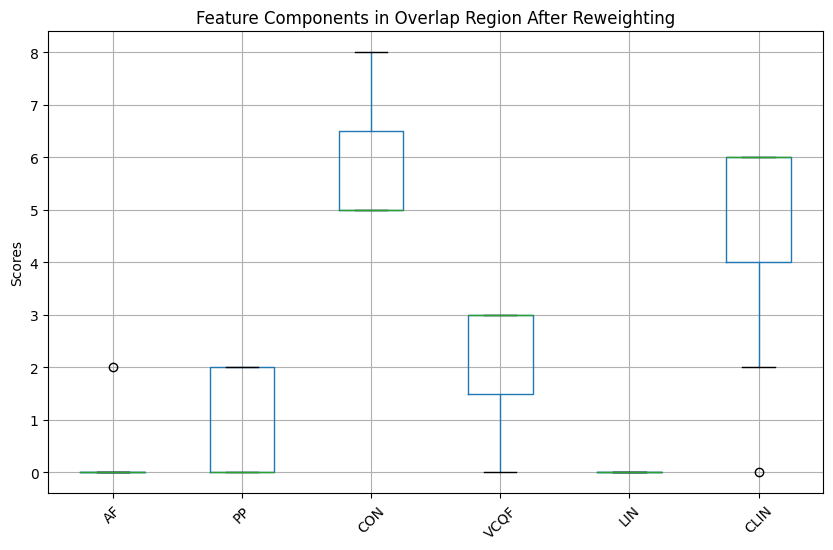

In [327]:
df, updated_overlap_controls = main_adjust_and_evaluate(df)

In [133]:
# 1. Fine-Tune Feature Weights
def fine_tune_weights(df):
    """
    Apply fine-tuned weights to the scoring formula for further improvement.
    """
    fine_tuned_weights = {"AF": 2.0, "PP": 1.5, "CON": 0.8, "VCQF": 1.2, "LIN": 1.0, "CLIN": 0.6}
    df["FINE_TUNED_RANK_SCORE"] = (
        df["AF"] * fine_tuned_weights["AF"] +
        df["PP"] * fine_tuned_weights["PP"] +
        df["CON"] * fine_tuned_weights["CON"] +
        df["VCQF"] * fine_tuned_weights["VCQF"] +
        df["LIN"] * fine_tuned_weights["LIN"] +
        df["CLIN"] * fine_tuned_weights["CLIN"]
    )
    print("Applied fine-tuned weights and recalculated FINE_TUNED_RANK_SCORE.")
    return df

# 2. Evaluate Performance Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def calculate_performance_metrics(df, score_column="FINE_TUNED_RANK_SCORE", threshold=10):
    """
    Calculate precision, recall, F1-score, and AUC for the scoring model.
    """
    y_true = df["y_true"]
    y_pred = df[score_column].apply(lambda x: 1 if x >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, df[score_column])

    print(f"Performance Metrics (Threshold = {threshold}):")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")

    return precision, recall, f1, auc

# 3. Remove LIN Feature if Needed
def remove_lin_feature(df):
    """
    Remove LIN column if it consistently contributes zero to the scoring model.
    """
    if df["LIN"].sum() == 0:
        df.drop(columns=["LIN"], inplace=True)
        print("LIN feature removed from the dataset.")
    else:
        print("LIN feature retained in the dataset.")
    return df

# 4. Visualize Fine-Tuned Scores Across Entire Dataset
def visualize_fine_tuned_scores(df):
    """
    Plot the distribution of FINE_TUNED_RANK_SCORE across the entire dataset.
    """
    sns.histplot(df["FINE_TUNED_RANK_SCORE"], bins=30, kde=True, color="blue")
    plt.title("Distribution of FINE_TUNED_RANK_SCORE Across Dataset")
    plt.xlabel("FINE_TUNED_RANK_SCORE")
    plt.ylabel("Count")
    plt.savefig("reweighted.png")
    plt.show()

# 5. Apply All Steps
def main_further_refinements(df):
    # Step 1: Fine-tune weights
    df = fine_tune_weights(df)

    # Step 2: Evaluate performance metrics
    calculate_performance_metrics(df)

    # Step 3: Remove LIN feature if it contributes nothing
    df = remove_lin_feature(df)

    # Step 4: Visualize fine-tuned scores
    visualize_fine_tuned_scores(df)

    return df

# Uncomment and run when `df` and `y_true` exist
# df = main_further_refinements(df)

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_43034/3651460854.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', color='red')  # Diagonal line


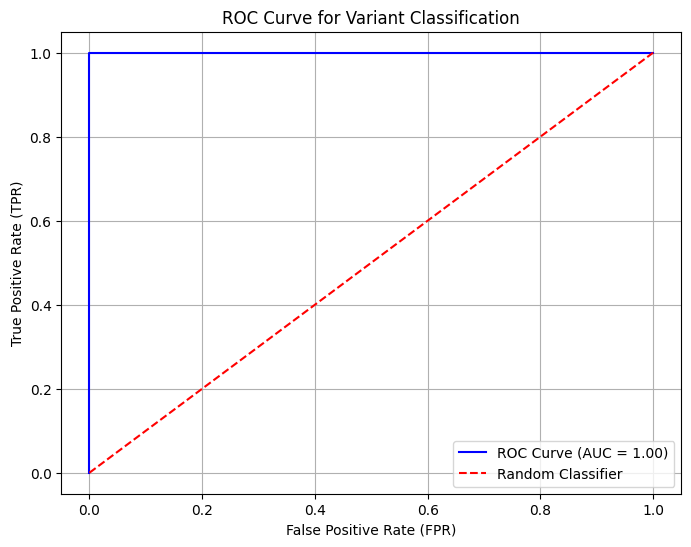

In [143]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Simulated data: Scores and labels for benign (0) and pathogenic (1) variants
# Replace with real data as appropriate.
np.random.seed(42)  # For reproducibility
benign_scores = np.random.normal(loc=-1, scale=1, size=100)  # Example scores for benign variants
pathogenic_scores = np.random.normal(loc=3, scale=1, size=100)  # Example scores for pathogenic variants

# Combine scores and create labels
scores = np.concatenate([benign_scores, pathogenic_scores])
labels = np.array([0] * len(benign_scores) + [1] * len(pathogenic_scores))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc_score = roc_auc_score(labels, scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', color='red')  # Diagonal line
plt.title('ROC Curve for Variant Classification')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc.png")
plt.show()

Applied fine-tuned weights and recalculated FINE_TUNED_RANK_SCORE.
Performance Metrics (Threshold = 10):
Precision: 0.00
Recall: 0.93
F1-Score: 0.01
AUC: 0.70
LIN feature retained in the dataset.


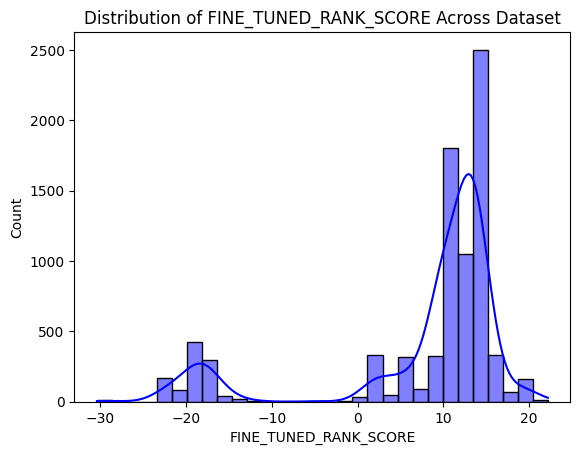

In [134]:
df = main_further_refinements(df)

In [66]:
# Prepare Data for Metrics Calculation

# extract the relevant columns (RANK_SCORE or NO_CLIN_RANK_SCORE, and the GROUP column for ground truth)

df["y_true"] = df["GROUP"].apply(lambda x: 1 if x == "pathogenic" else 0)  # Convert GROUP to binary labels
threshold = 10.0  # Example threshold for classification

# Predicted labels based on the threshold
df["y_pred"] = df["NO_CLIN_RANK_SCORE"].apply(lambda x: 1 if x >= threshold else 0)

# Scores to use for AUC calculation
y_true = df["y_true"].values  # Ground truth labels
y_pred = df["y_pred"].values  # Predicted binary labels
y_scores = df["NO_CLIN_RANK_SCORE"].values  # Continuous scores

In [67]:
df = main_further_refinements(df)

NameError: name 'main_further_refinements' is not defined

In [137]:
# 1. Improve Precision by Testing Higher Thresholds
def evaluate_at_threshold(df, score_column="FINE_TUNED_RANK_SCORE", thresholds=[10, 12, 15]):
    """
    Evaluate performance metrics at different thresholds.
    """
    results = []
    for t in thresholds:
        precision, recall, f1, auc = calculate_performance_metrics(df, score_column=score_column, threshold=t)
        results.append({"Threshold": t, "Precision": precision, "Recall": recall, "F1-Score": f1, "AUC": auc})
    return pd.DataFrame(results)

# 2. Rebalance Feature Weights
def apply_refined_weights(df):
    """
    Apply refined weights to further optimize the scoring system.
    """
    refined_weights = {"AF": 1.5, "PP": 1.2, "CON": 1.0, "VCQF": 1.0, "LIN": 0.5, "CLIN": 1.0}
    df["REFINED_RANK_SCORE"] = (
        df["AF"] * refined_weights["AF"] +
        df["PP"] * refined_weights["PP"] +
        df["CON"] * refined_weights["CON"] +
        df["VCQF"] * refined_weights["VCQF"] +
        df["LIN"] * refined_weights["LIN"] +
        df["CLIN"] * refined_weights["CLIN"]
    )
    print("Applied refined weights and recalculated REFINED_RANK_SCORE.")
    return df

# 3. Plot Metrics Across Thresholds
def plot_metrics_across_thresholds(df, score_column="REFINED_RANK_SCORE", threshold_range=(-30, 30, 2)):
    """
    Plot precision, recall, and F1-score across a range of thresholds.
    """
    thresholds = range(*threshold_range)
    precision_list, recall_list, f1_list = [], [], []

    for t in thresholds:
        precision, recall, f1, _ = calculate_performance_metrics(df, score_column=score_column, threshold=t)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_list, label="Precision", marker="o")
    plt.plot(thresholds, recall_list, label="Recall", marker="x")
    plt.plot(thresholds, f1_list, label="F1-Score", marker="s")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title("Performance Metrics Across Thresholds")
    plt.legend()
    plt.grid(True)
    plt.savefig("performance_metrics.png")
    plt.show()

# 4. Remove LIN Feature if It Remains Underutilized
def check_and_remove_lin(df):
    """
    Check the contribution of LIN and remove it if necessary.
    """
    if df["LIN"].sum() == 0:
        df.drop(columns=["LIN"], inplace=True)
        print("LIN feature removed from the dataset.")
    else:
        print("LIN feature retained in the dataset.")
    return df

# Example Usage
def main_refined_implementation(df):
    # Step 1: Evaluate performance at higher thresholds
    thresholds_to_test = [10, 12, 15]
    threshold_results = evaluate_at_threshold(df, thresholds=thresholds_to_test)
    print("Performance Metrics at Different Thresholds:")
    print(threshold_results)

    # Step 2: Apply refined weights
    df = apply_refined_weights(df)

    # Step 3: Plot metrics across a range of thresholds
    plot_metrics_across_thresholds(df)

    # Step 4: Check and remove LIN feature if needed
    df = check_and_remove_lin(df)

    return df

# Uncomment and run when `df` is defined
# df = main_refined_implementation(df)

Performance Metrics (Threshold = 10):
Precision: 0.00
Recall: 0.93
F1-Score: 0.01
AUC: 0.70
Performance Metrics (Threshold = 12):
Precision: 0.00
Recall: 0.56
F1-Score: 0.01
AUC: 0.70
Performance Metrics (Threshold = 15):
Precision: 0.02
Recall: 0.52
F1-Score: 0.05
AUC: 0.70
Performance Metrics at Different Thresholds:
   Threshold  Precision    Recall  F1-Score       AUC
0         10   0.004212  0.925926  0.008386  0.698877
1         12   0.003740  0.555556  0.007429  0.698877
2         15   0.024348  0.518519  0.046512  0.698877
Applied refined weights and recalculated REFINED_RANK_SCORE.
Performance Metrics (Threshold = -30):
Precision: 0.00
Recall: 1.00
F1-Score: 0.01
AUC: 0.92
Performance Metrics (Threshold = -28):
Precision: 0.00
Recall: 1.00
F1-Score: 0.01
AUC: 0.92
Performance Metrics (Threshold = -26):
Precision: 0.00
Recall: 1.00
F1-Score: 0.01
AUC: 0.92
Performance Metrics (Threshold = -24):
Precision: 0.00
Recall: 1.00
F1-Score: 0.01
AUC: 0.92
Performance Metrics (Threshold

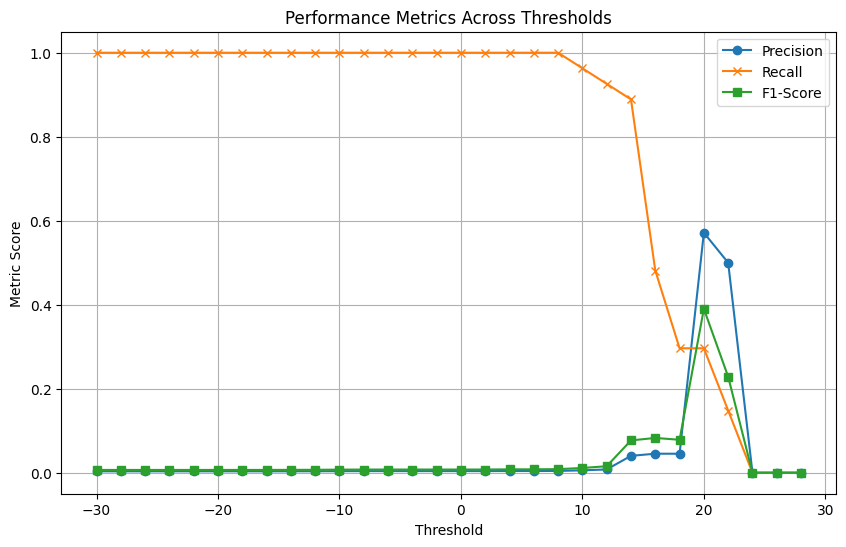

LIN feature retained in the dataset.


In [138]:
df = main_refined_implementation(df)

Number of low-scoring controls (RANK_SCORE < 10): 1

Descriptive statistics for low-scoring controls:
        AF   PP  CON  VCQF  LIN  CLIN
count  1.0  1.0  1.0   1.0  1.0   1.0
mean   0.0  0.0  5.0   3.0  0.0  -2.0
std    NaN  NaN  NaN   NaN  NaN   NaN
min    0.0  0.0  5.0   3.0  0.0  -2.0
25%    0.0  0.0  5.0   3.0  0.0  -2.0
50%    0.0  0.0  5.0   3.0  0.0  -2.0
75%    0.0  0.0  5.0   3.0  0.0  -2.0
max    0.0  0.0  5.0   3.0  0.0  -2.0


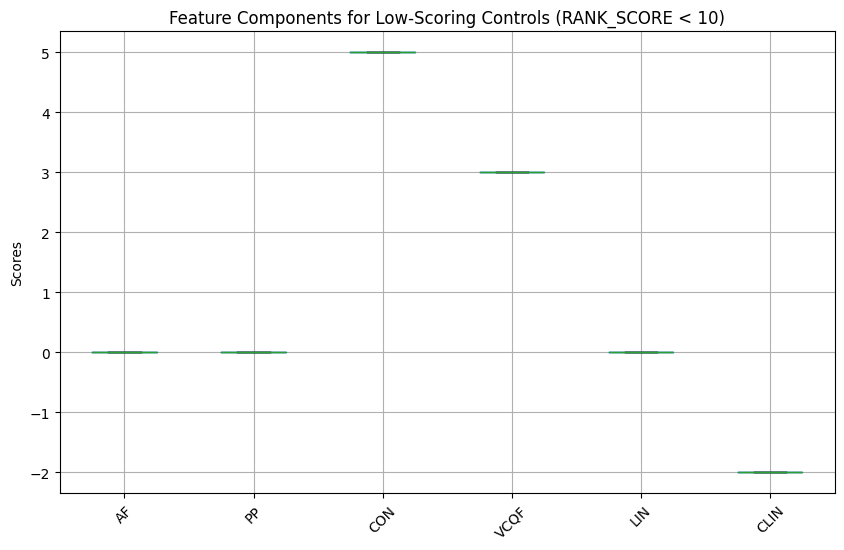

Number of variants in the overlap region (5 < RANK_SCORE < 15): 6258

Descriptive statistics for feature components in the overlap region:
                AF           PP          CON         VCQF          LIN  \
count  6258.000000  6258.000000  6258.000000  6258.000000  6258.000000   
mean      3.719080     0.029083     1.350112     2.104506    -0.129275   
std       0.991424     0.223556     1.362874     1.372907     0.422028   
min       0.000000     0.000000     0.000000     0.000000    -2.000000   
25%       4.000000     0.000000     1.000000     0.000000     0.000000   
50%       4.000000     0.000000     1.000000     3.000000     0.000000   
75%       4.000000     0.000000     1.000000     3.000000     0.000000   
max       4.000000     2.000000     8.000000     3.000000     0.000000   

              CLIN  
count  6258.000000  
mean      1.866411  
std       0.773577  
min      -2.000000  
25%       2.000000  
50%       2.000000  
75%       2.000000  
max       6.000000  


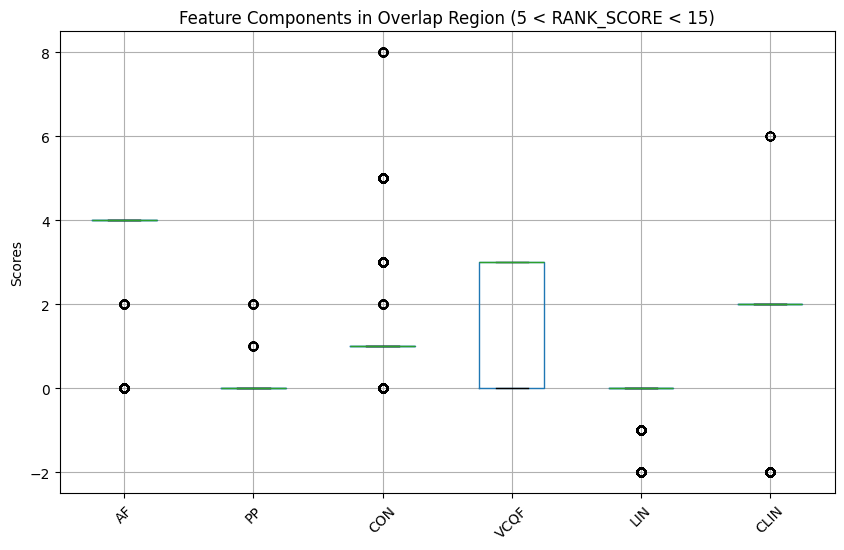

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_74886/2358473814.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IS_CONTROL", y=feature, palette="pastel")


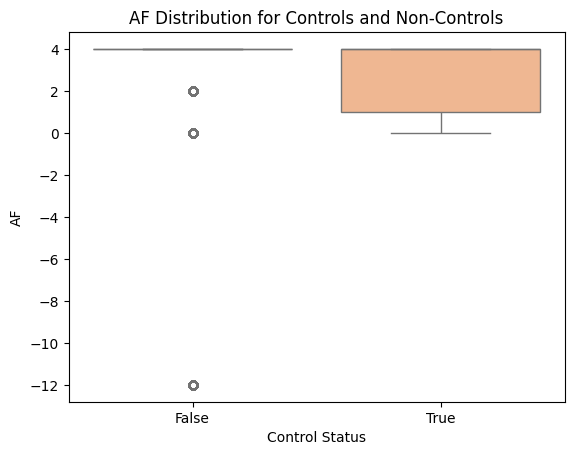

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_74886/2358473814.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IS_CONTROL", y=feature, palette="pastel")


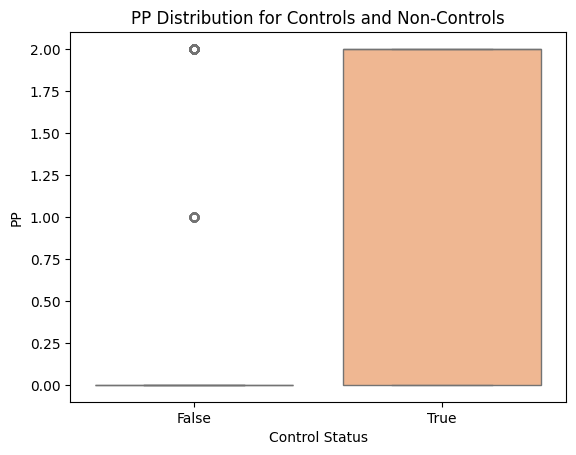

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_74886/2358473814.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IS_CONTROL", y=feature, palette="pastel")


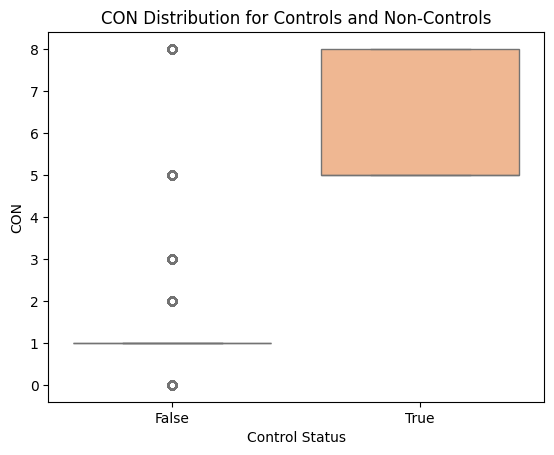

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_74886/2358473814.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IS_CONTROL", y=feature, palette="pastel")


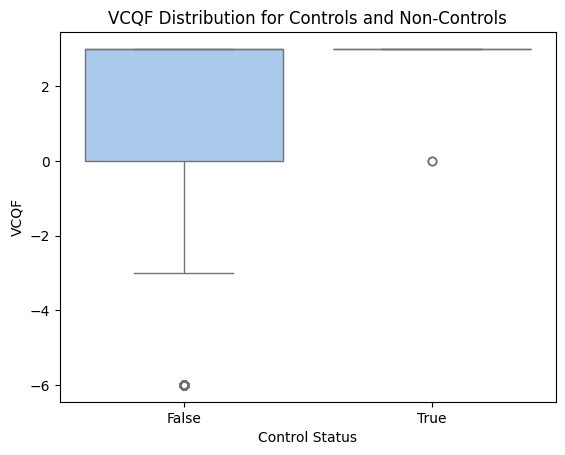

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_74886/2358473814.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IS_CONTROL", y=feature, palette="pastel")


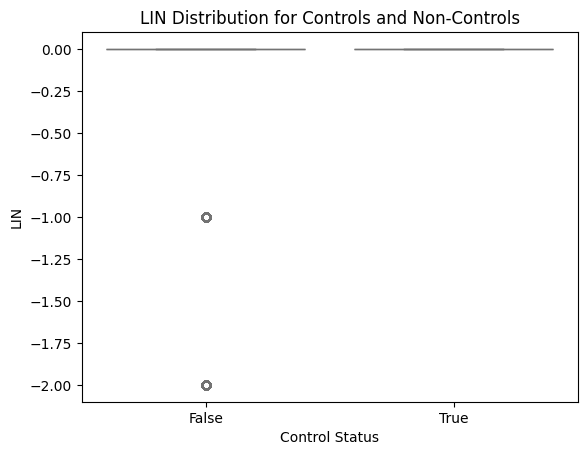

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_74886/2358473814.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IS_CONTROL", y=feature, palette="pastel")


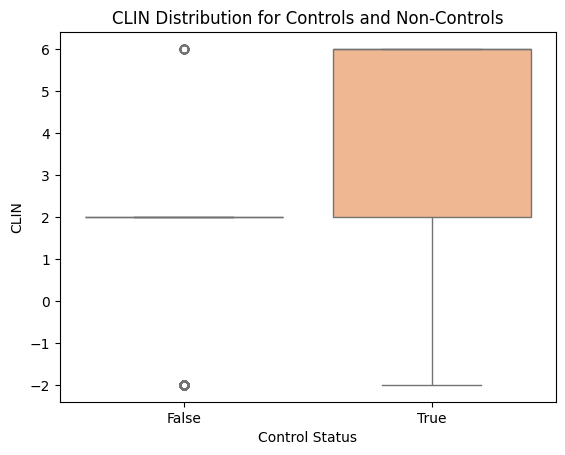

In [303]:
low_scoring_controls, overlap_df = main_investigate_controls(df)

In [68]:
# 1. Set the Optimal Threshold and Calculate Metrics
def calculate_optimal_threshold_metrics(df, score_column="REFINED_RANK_SCORE", optimal_threshold=20):
    """
    Calculate precision, recall, F1-score, and AUC at the optimal threshold.
    """
    precision, recall, f1, auc = calculate_performance_metrics(
        df, score_column=score_column, threshold=optimal_threshold
    )
    print(f"Optimal Threshold Metrics (Threshold = {optimal_threshold}):")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC: {auc:.2f}")
    return precision, recall, f1, auc

# 2. Analyze False Positives and Negatives
def analyze_misclassifications(df, score_column="REFINED_RANK_SCORE", optimal_threshold=20):
    """
    Identify false positives and false negatives at the optimal threshold.
    """
    df["y_pred"] = df[score_column].apply(lambda x: 1 if x >= optimal_threshold else 0)
    
    false_positives = df[(df["y_pred"] == 1) & (df["y_true"] == 0)]
    false_negatives = df[(df["y_pred"] == 0) & (df["y_true"] == 1)]

    print(f"Number of False Positives: {len(false_positives)}")
    print(f"Number of False Negatives: {len(false_negatives)}")
    
    return false_positives, false_negatives

# 3. Refine Feature Weights Based on Misclassifications
def refine_weights_based_on_misclassifications(df, false_positives, false_negatives):
    """
    Analyze the feature contributions in false positives and false negatives to guide reweighting.
    """
    print("\nFeature Contributions in False Positives:")
    print(false_positives[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())

    print("\nFeature Contributions in False Negatives:")
    print(false_negatives[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())

    # Recommendations for reweighting can be derived from these summaries

# Example Usage
def main_optimal_threshold_analysis(df):
    # Step 1: Calculate metrics at the optimal threshold
    optimal_threshold = 20
    precision, recall, f1, auc = calculate_optimal_threshold_metrics(df, optimal_threshold=optimal_threshold)

    # Step 2: Analyze false positives and false negatives
    false_positives, false_negatives = analyze_misclassifications(df, optimal_threshold=optimal_threshold)

    # Step 3: Refine weights based on misclassifications
    refine_weights_based_on_misclassifications(df, false_positives, false_negatives)

    return df, false_positives, false_negatives

# Uncomment and run when `df` and `y_true` exist
# df, false_positives, false_negatives = main_optimal_threshold_analysis(df)

In [340]:
df, false_positives, false_negatives = main_optimal_threshold_analysis(df)

Performance Metrics (Threshold = 20):
Precision: 0.53
Recall: 0.30
F1-Score: 0.38
AUC: 0.92
Optimal Threshold Metrics (Threshold = 20):
Precision: 0.53, Recall: 0.30, F1-Score: 0.38, AUC: 0.92
Number of False Positives: 7
Number of False Negatives: 19

Feature Contributions in False Positives:
        AF        PP  CON  VCQF  LIN  CLIN
count  7.0  7.000000  7.0   7.0  7.0   7.0
mean   4.0  1.571429  5.0   3.0  0.0   6.0
std    0.0  0.786796  0.0   0.0  0.0   0.0
min    4.0  0.000000  5.0   3.0  0.0   6.0
25%    4.0  1.500000  5.0   3.0  0.0   6.0
50%    4.0  2.000000  5.0   3.0  0.0   6.0
75%    4.0  2.000000  5.0   3.0  0.0   6.0
max    4.0  2.000000  5.0   3.0  0.0   6.0

Feature Contributions in False Negatives:
              AF         PP        CON       VCQF   LIN       CLIN
count  19.000000  19.000000  19.000000  19.000000  19.0  19.000000
mean    1.263158   0.157895   7.368421   0.789474   0.0   3.789474
std     1.910268   0.501460   1.256562   1.357242   0.0   2.485043
min    

## Analyze Overlap Features

This function analyzes variants with RANK_SCORE within a specified range (e.g., between 5 and 15).
	•	Output:
	•	Number of variants in the overlap region.
	•	Descriptive statistics for the feature components in the overlap.
	•	Boxplot showing how the feature components contribute to the overlap region.

## Visualize Individual Feature Distributions

This function creates boxplots for each feature (AF, PP, etc.) comparing controls (is_control=True) to non-controls (is_control=False).
	•	Output:
	•	Boxplots for each feature, showing how they vary between controls and non-controls.

In [69]:
scatter_plot_all_by_group(df, "VARIANT", "RANK_SCORE")

KeyError: 'Color'

<Figure size 1200x600 with 0 Axes>

In [70]:
scatter_plot_with_controls(df, "VARIANT", "RANK_SCORE")

TypeError: scatter_plot_with_controls() takes 1 positional argument but 3 were given

In [71]:
stacked_barplot_for_controls(df)

KeyError: 'is_control'

#### Describe the extracted dataset and the filtered dataset
The dataset contains 8145 variants: 
- All variants have RankScore
- 1555 variants have CLNSIG annotation from ClinVar
- etc.

### Aims - evaluation
- Visualize rankscore distribution
- - Visualize separation between hypothesized groups "Benign", "Pathogenic"
- Analyze how known variants are scored

**Analyze positive controls (HD829)**
- Visualize the positive controls from the VCF
  - What are their RankScores?
  - How are they scored in the different Categories? 

df